# Nonadiabatic dynamics based on exact factorization in Libra


## Table of Content: <a name="TOC"></a>
1. [Generic setups](#1)

2. [Theoretical Background and Algorithms](#2)

   2.1. [Decoherence-Induced Surface Hopping based on XF (DISH-XF) or SHXF](#2.1)
   
   2.2. [Mixed Quantum-Classical based on XF (MQCXF)](#2.2)
   
   2.3. [Turning-Point Algorithms](#2.3)
   
   2.4. [Time-Dependent Width Approximations](#2.4)

3. [Model Hamiltonians](#3)

4. [Choosing the Nonadiabatic Dynamics Methodology](#4)

5. [Choosing initial conditions: Nuclear and Electronic](#5)

6. [Running the calculations](#6)

7. [Plotting the results](#7)

8. [Comparison with quantum dynamics](#8)

   8.1. [Run the quantum dynamics](#8.1)
   
   8.2. [Plot the population and coherence indicators](#8.2)

9. [Phase-space diagrams](#9)

10. [Dynamics snapshots](#10)

11. [Time-Dependent Width Approximations](#11)

## A. Learning objectives

- to understand the XF-based NA-MD methods in Libra
- to be able to setup such NA-MD calculations with model Hamiltonians
- to be able to plot diabatic and adiabatic surfaces and NACs along the nuclear coordinate for model Hamiltonians
- to be able to setup initial conditions for electronic and nuclear degrees of freedom
- to be able to plot the key results of NA-MD simulations
- to be able to plot the XF-related properties
- to run the DVR dynamics and compare the dynamics properties between the NA-MD and exact calculations
- to monitor the nuclear motions in the NA-MD and exact calculations
- to utilize various algorithms such as the branching correction and time-dependent widths for propagating the auxiliary variables


## B. Use cases

- [Plot 1D PES](#)


## C. Functions

- `libra_py`
  - `dynamics_plotting`
    - [`plot_surfaces`](#plot_surfaces-1) 
  - `dynamics`
    - `tsh`
      - `compute`
        - [`generic_recipe`](#generic_recipe-1)
      - `plot`
        - [`plot_dynamics`](#plot_dynamics-1)
        - [`plot_dynamics_xf`](#plot_dynamics_xf-1)
  - `models`     
     - `Holstein`
       - [`Holstein2`](#Holstein2-1)
     - `Tully`
       - [`Tully3`](#Tully3-1)
     - `Subotnik`
       - [`double_arch_geometry`](#double_arch_geometry-1)
     - `Esch_Levine`
       - [`JCP_2020`](#Esch_Levine_JCP_2020-1)

## 1. Generic setups
<a name="1"></a>[Back to TOC](#TOC)

Here, we import all necessary libraries, set up some definitions (e.g. colors), and define the function that would be calling model Hamiltonians also defined within Libra package.

Necessary parameters for the exact factorization (XF) methods (SHXF, MQCXF, MFXF) and comparison groups (FSSH, SDM, BCSH) are imported from the recipes directory. Packages that set dynamic parameters are imported from the recipes directory. Their names specify their corresponding nonadiabatic dynamics methods.

    from recipes import shxf, mqcxf, ehxf
    from recipes import fssh, sdm, bcsh

In [1]:
import sys
import cmath
import math
import os
import h5py
import matplotlib.pyplot as plt   # plots
import matplotlib.animation as animation
import matplotlib.colors as clrs
import numpy as np
import time
import warnings

from liblibra_core import *
import util.libutil as comn
from libra_py import units
import libra_py.models.Holstein as Holstein
import libra_py.models.Tully as Tully
import libra_py.models.Subotnik as Subotnik
import libra_py.models.Esch_Levine as Esch_Levine
from libra_py import dynamics_plotting
import libra_py.dynamics.tsh.compute as tsh_dynamics
import libra_py.dynamics.tsh.plot as tsh_dynamics_plot
import libra_py.data_savers as data_savers
import libra_py.data_read as data_read
import libra_py.data_visualize as data_visualize

from recipes import shxf, mqcxf, mfxf
from recipes import fssh, sdm

import libra_py.dynamics.exact.compute as dvr
import libra_py.dynamics.exact.save as dvr_save

#from matplotlib.mlab import griddata
#%matplotlib inline 
warnings.filterwarnings('ignore')

colors = {}
colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   
colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      
colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  
colors.update({"41": "#2F4F4F"})  # darkslategray
colors.update({"51": "#000000"}) 

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/home/daehohan/miniconda3/envs/libra2/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/daehohan/miniconda3/envs/libra2/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/daehohan/miniconda3/envs/libra2/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<flo

## 2. Theoretical Background and Algorithms
<a name="2"></a>[Back to TOC](#TOC)

XF is a wave function ansatz in which the total wave function is separated into a nuclear wave function and its conditional electronic wave function, represented as:

$$\Psi(\mathbf{r},\mathbf{R},t)=\chi(\mathbf{R},t)\Phi_{\mathbf{R}}(\mathbf{r},t).$$

Based on XF, the mixed quantum-classical (MQC) equations have been formulated for trajectory-based nonadiabatic dynamics:  
$$ i\hbar \frac{d}{dt}\Phi_{\mathbf{R}}(\mathbf{r},t)= \left[ H_{BO}(\mathbf{r};\mathbf{R})+\sum_{\nu}\frac{-\mathcal{P}_{\nu}}{M_{\nu}}\cdot (\mathbf{A}_{\nu}+i\hbar \nabla_{\nu}) \right]\Phi_{\mathbf{R}}(\mathbf{r},t), $$

$$ \mathbf{F}_{\nu}=\mathbf{F}_{\nu}^{MF} + \mathbf{F}_{\nu}^{XF} = -\langle \Phi_{\mathbf{R}}|\nabla_{\nu}\hat{H}_{BO}|\Phi_{\mathbf{R}}\rangle_{\mathbf{r}}+\sum_{\nu'}\frac{2i\mathcal{P}_{\nu'}}{\hbar M_{\nu'}}\cdot\left(\mathbf{A}_{\nu'}\mathbf{A}_{\nu}-\hbar^{2} \Re \langle \nabla_{\nu'}\Phi_{\mathbf{R}}(t)|\nabla_{\nu}\Phi_{\mathbf{R}}(t)\rangle_{\mathbf{r}}\right).$$

Beyond the conventional Ehrenfest terms, additional terms—constructed using the time-dependent vector potential $\mathbf{A}_{\nu}$ and  quantum momentum $\mathcal{P}_{\nu}$—explicitly describe the electron-nuclear correlation. $\mathbf{A}_{\nu}$ and $\mathcal{P}_{\nu}$ are defined as

$$ \mathbf{A}_{\nu}(\mathbf{R},t)=\langle \Phi_{\mathbf{R}}(t)|-i\hbar \nabla_{\nu} \Phi_{\mathbf{R}}(t)\rangle_{\mathbf{r}}, $$

$$ \mathcal{P}(\mathbf{R},t) = - \frac{i\hbar \nabla_{\nu}|\chi(\mathbf{R},t)|^{2}}{2|\chi(\mathbf{R},t)|^{2}}. $$

As the quantum momentum contains the information of the nuclear wave function, the quantum momentum needs to be approximated under the trajectory-based approximation.  To propagate MQC equations, one can use either the coupled-trajectory or the independent-trajectory approach. In the coupled-trajectory approach, a swarm of trajectories is propagated simultaneously, imitating the overall nuclear distribution. Conversly, in the indenpendent-trajectory approach, the propagation of electrons and nuclei is done under a single trajectory, and interactions from other trajectories are indirectly considered through the use of auxiliary trajectories. 

In this tutorial, we address independent-trajectory methods based on XF. According to the electronic/nuclear propagation and algorithmic difference, the methods are categorized into SHXF, MQCXF, and MFXF.

### 2.1 Decoherence-Induced Surface Hopping based on XF (DISH-XF) or SHXF
<a name="2.1"></a>[Back to TOC](#TOC)

 * `shxf` - this recipe defines the decoherence-induced surface hopping based on XF (DISH-XF) or SHXF method:
 
   Ha, J.-K.; Lee, I. S.; Min, S. K. Surface Hopping Dynamics beyond Nonadiabatic Couplings for Quantum Coherence. *J. Phys. Chem. Lett.* **2018**, 9, 1097. https://doi.org/10.1021/acs.jpclett.8b00060.

SHXF is is selected by: 

    dyn_general.update({"decoherence_algo":5 })

In the SHXF dynamics, the nuclear propagation is simplified by the conventional surface hopping procedure, thus 

    dyn_general.update({"tsh_method":0 })

The electronic propagation follows the electronic MQC equation, conducted in the adiabatic representation. The differential equation for adiabatic coefficients $C_{k}$ is given as

$$ \dot C_k(t) = -\frac{i}{\hbar}E_k(t)C_k(t)- \sum_j\sum_\nu{\bf d}_{kj\nu}(t)\cdot\dot{\bf R}_\nu(t)C_j(t) +\sum_j\sum_\nu\frac{i\mathcal{P}_{\nu}(\mathbf{R},t)}{\hbar M_\nu} \cdot\left\{{\bf f}_{j\nu}(t)-{\bf f}_{k\nu}(t)\right\}|C_j(t)|^2 C_k(t). $$

The quantum momentum is calculated by approximating each nuclear adibatic wavepacket to a Gaussian function.
$$ |\chi|^2 = \sum_{k}|\chi_{k}|^2 = \sum_{k}N_{k}\prod_\nu
         \exp\left(-\dfrac{|\textbf{R}_\nu-\textbf{R}_{k\nu}|^2}{2\sigma^2_{\nu}}\right). $$
The parameter for this width of a wavepacket corresponds to `dyn_general["wp_width"]`, which is a ndof x 1 matrix. The position of each adiabatic wave packet, $\textbf{R}_{k}$ is also estimated by propagating auxiliary trajectories. An auxiliary trajectory for the $k$th state is generated when its population becomes numerically finite, i.e., $\epsilon< |C_{k}|^{2}< 1-\epsilon$. This threshold $\epsilon$ is also a parameter, `dyn_general["coherence_threshold"]` (default: 0.1). After the creation of each auxiliary trajectory, its evolution is conducted by uniform velocity from the energy conservation:

$$ \sum_{\nu}\frac{1}{2}M_{\nu}\dot{\mathbf{R}}_{k\nu}^{2}(t)= \sum_{\nu}\frac{1}{2}M_{\nu}\dot{\mathbf{R}}_{\nu}^{2}(t)+E(t)-E_{k}(t). $$

Here, the auxiliary momenta $\mathbf{P}_{k\nu}$ are determined by scaling the real momenta, that is, $\mathbf{P}_{k\nu}=\alpha \mathbf{P}_{\nu}$. While auxiliary trajectories are propagated in the interval $[t_{0}, t]$, the spatial derivative of phase $\mathbf{f}_{k\nu}$ is computed by the change of momentum as follows.
$$ \mathbf{f}_{k\nu}(t) = -\int_{t_{0}}^{t} \nabla_{\nu}E_{k}(\tau) d\tau \approx M_{\nu}\dot{\mathbf{R}}_{k\nu}(t) - M_{\nu}\dot{\mathbf{R}}_{k\nu}(t_{0}). $$


When there are auxiliary trajectories, the quantum momenta are computed by
$$ \mathcal{P}_{\nu}(\mathbf{R},t)=\frac{i\hbar}{2 \sigma_{\nu}} \left(\mathbf{R}_{a\nu}-\sum_{k} \rho_{kk} \mathbf{R}_{k\nu} \right). $$
Here, $\mathbf{R}_{a\nu}$ is the auxiliary trajectory for the active state $a$. In the case of SHXF, the nuclear motion just follows the active-state potential surface exactly, thus $\mathbf{R}_{a\nu}=\mathbf{R}_{\nu}$.

### 2.2 Mixed Quantum-Classical based on XF (MQCXF)
<a name="2.2"></a>[Back to TOC](#TOC)

 * `mqcxf` - this recipe defines the mixed quantum-classical based on XF method:
 
   Ha, J.-K.; Min, S. K. Independent Trajectory Mixed Quantum-Classical Approaches Based on the Exact Factorization. *J. Chem. Phys.* **2022**, 156, 174109. https://doi.org/10.1063/5.0084493.
   
MQCXF is is selected by: 

    dyn_general.update({"decoherence_algo":6 })
    
Just as the SHXF is a surface-hopping variant based on XF, the MQCXF is an Ehrenfest or mean-field (MF) variant based on XF. Unlike SHXF, MQCXF employs the decoherence force from XF to propagate nuclei, thus

    dyn_general.update({"use_xf_force":1 })

The hopping procedure is utilized in MQCXF as well, thus

    dyn_general.update({"tsh_method":0 })
    
However, one should note that the active state in MQCXF does not serve the force directly. Instead, the active state functions as a pointer state, indicating the direction of decoherence by adjusting the quantum momenta.

For energy conservation, we compute the phase gradient $\mathbf{f}_{k\nu}$ in a different way from SHXF. The phase gradient follows the energy-based approximation. In the energy-based approximation, the phase gradient is set to be proportional to the nuclear momenta:
$$ \mathbf{f}_{k\nu}=-\mathbf{P}_{\nu} \frac{E_k}{2(T+\delta T)}. $$
Here, $T$ is the kinetic energy and $\delta T$ is a parameter for excluding the vanishing denominator in the expression, determined by `dyn_general["e_mask"]` (default: 0.0001). Although this expression cannot be a perfect remedy considering classical turning points ($T=0$), it partially resolves the non-energy conserving problem of the original decoherence force based on XF.

One can neglect the XF decoherence force completely in order to keep the mean-field expression of the force, which corresponds to mean-field based on XF (MFXF) or Ehrenfest based on XF (EhXF).

 * `mfxf` - this recipe defines the mean-field based on XF method:

    Arribas, E. V.; Vindel-Zandbergen, P.; Roy, S.; Maitra, N. T. Different Flavors of Exact-Factorization-Based Mixed Quantum-Classical Methods for Multistate Dynamics. *Phys. Chem. Chem. Phys.* **2023**, 25, 26380–26395. https://doi.org/10.1039/D3CP03464J.

The recipes for MFXF is the same as MQCXF except we turn off the XF force.

    dyn_general.update({"use_xf_force":0 })

However, the MFXF method is not recommended to use, since its force is non-energy conserving fundamentally.

### 2.3 Turning-Point Algorithms
<a name="2.3"></a>[Back to TOC](#TOC)

In the auxiliary-trajectory propagation, there are issues when classical turning points are involved during the dynamics. There are two possibilities: (I) an auxiliary trajectory can meet a turning point. (II) the real trajectory can encounter a turning point. In both cases, the following algorithms need to be utilized, since directions of auxiliary momenta determined by positive scalings of real momenta become unphysical.

*Case I.* The situation that an auxiliary trajectory meets a turning point means that there is no real scaling factor $\alpha$ to satisfy the energy conservation condition, which is classically forbidden. In that case, we set the corresponding auxiliary momentum $\mathbf{P}_{k\nu}$ to zero by setting $\alpha:=0$. Another treatment, inspired by the branching-correction (BC) algorithm (Xu, J.; Wang, L. *J. Chem. Phys.* **2019**, 150, 164101.), is to project out the auxiliary trajectory $\{\mathbf{R}_{k\nu}, \mathbf{P}_{k\nu} \}$ by resetting the coefficient $C_{k}:=0$ and renormalize the density (see the above PCCP.). This option can be set by the following.

    dyn_general.update({"project_out_aux":1 })

*Case II.* When the dynamics encounters a turning point, the direction of real momenta is reversed. Then directions of all auxiliary momenta are reversed discontinously following that, even though wave packet splitting between states would be expected in this situation. For mimicking this branching, the default option is to collapse the density into the current active state (`dyn_general["tp_algo"]=1`) based on the BC algorithm. Additional options are to control relative motions between real and auxiliary trajectories by fixing auxiliary trajectories (`dyn_general["tp_algo"]=2`) or keeping the last momenta in auxiliary trajectories (`dyn_general["tp_algo"]=3`).

The BC algorithms are recommended to use when turning points are involved during the dynamics, although these can cause total energy drifts in MQCXF due to projection or collapse into a classically forbidden state.

### 2.4 Time-Dependent Width Approximations
<a name="2.4"></a>[Back to TOC](#TOC)

Instead of using a fixed Gaussian width for computing the quantum momenta, we can use time-dependent widths. The available options for the width are below.

*The fixed-width approximation (default):*

    dyn_general.update({"use_td_width":0 })

For all trajectories, we use the fixed width for each degree of freedom defined by `dyn_general["wp_width"]`. `dyn_general["wp_width"]` is given as an ndof x 1 matrix.

*The free-particle Gaussian wave packet approximation:*

    dyn_general.update({"use_td_width":1 })

The width follows the expression of a free-particle Gaussian.
$$ \sigma_{\nu}^{2}(t) = \sigma_{\nu}^{2}(0) + (v_{\nu}t)^{2}. $$
In this case, `dyn_general["wp_width"]` stands for the initial wave packet width $\sigma_{\nu}(0)$, and the velocity $v_{\nu}$ is set by another parameter `dyn_general["wp_v"]`, which is an ndof x 1 matrix as well.

*The Schwartz approximation:*

    dyn_general.update({"use_td_width":2 })

In this approximation, the width is computed with the instantaneous de Broglie wavelength $\lambda_{D,\nu}=h/P_{\nu}$ following the work of Schwartz's group (Bedard-Hearn, M. J.; Larsen, R. E.; Schwartz, B. J. *J. Chem. Phys.* **2005**, 123, 234106.).
$$ \sigma_{\nu}^{-2}(t)= \left( \frac{\left(w_{\nu}/\mathrm{Bohr}\right)^{2}}{2\lambda_{D,\nu}} \right)^{2}. $$
Here, $w_{\nu}$ is the interaction width paramter given by `dyn_general["wp_width"]`.

*The Subotnik approximation:*

    dyn_general.update({"use_td_width":3 })

In this approximation, the width is computed with the internal auxiliary variables based on the maximum wave packet overlap conjecture proposed by Subotnik (Subotnik, J. E. *J. Phys. Chem. A* **2011**, 115, 12083–12096.). Thus, the width parameter `dyn_general["wp_width"]` is redundant in the case. The pairwise Gaussian width $\sigma_{jk, \nu}^{2}$ is given as
$$ \sigma_{jk, \nu}^{2}=\hbar \frac{|\mathbf{R}_{j\nu}-\mathbf{R}_{k\nu}|}{|\mathbf{P}_{j\nu}-\mathbf{P}_{k\nu}|}, $$
and the total width is generalized by the pairwise average.
$$ \sigma_{\nu}^{-2} = \frac{1}{N-1}\sum_{j,k=0, j<k}^{N-1} \sigma_{jk, \nu}^{-2}.$$

## 3. Model Hamiltonians
<a name="3"></a>[Back to TOC](#TOC)

Let's define the `compute_model` function that returns all the necessary objects and properties for the dynamics. 

In [2]:
def compute_model(q, params, full_id):

    model = params["model"]
    res = None
    
    if model==1:        
        res = Holstein.Holstein2(q, params, full_id) 
    elif model==2:
        res = Tully.Tully3(q, params, full_id)
    elif model==3:
        res = Subotnik.double_arch_geometry(q, params, full_id)
    elif model==4:
        res = Esch_Levine.JCP_2020(q, params, full_id)
    else:
        pass            

    return res

The parameters for candidate models are given as:

* Sets 1 and 2 - for the single-crossing and double-crossing Holstein Hamiltonians These are just parabolas with constant coupling.
* Sets 3 - for the ECWR (Extended Coupling With Reflection) Tully model
* Sets 4 - for the DAG (Double Arch Geometry) or symmetrized ECWR Tully model
* Sets 5 - for the 3-level Esch-Levine Hamiltonians. These are just lines or bundles of lines crossing with yet another line and having a constant coupling.

In [3]:
model_params1 = {"model":1, "model0":1, "nstates":2, "E_n":[0.0,  0.0], "x_n":[0.0,  2.5],"k_n":[0.002, 0.005],"V":0.001}
model_params2 = {"model":1, "model0":1, "nstates":2, "E_n":[0.0, -0.01], "x_n":[0.0,  0.5],"k_n":[0.002, 0.008],"V":0.001}

model_params3 = {"model":2, "model0":2, "nstates":2} # ECWR
model_params4 = {"model":3, "model0":3, "nstates":2} # DAG

model_params5 = {"model":4, "model0":4, "nstates":3, 
                 "w0":0.015, "w1":0.005, "V":0.005, "eps":0.0, "i_crit":3, "delta":0.01 } # Esch-Levine

all_model_params = [model_params1, model_params2, model_params3, model_params4, 
                    model_params5]

Choose the model to simulate here by setting `model_indx`.

In [4]:
# 0 - Single-crossing (SC) Holstein, 2 level
# 1 - Double-crossing (DC) Holstein, 2 level
# 2 - Tully, extended crossing with reflection (ECWR), 2 level
# 3 - Double arch geometry or symmetrized ECWR, 2 level
# 4 - Esch-Levine, 1 crosses 2 parallel, 3 level

#################################
# Give the model used an index
model_indx = 2
################################

model_params = all_model_params[model_indx]

Here, visualization of each model system is done. Change parameters accordingly.

In [5]:
# New plotting:
# Common setups
plot_params = {"figsize":[24, 6], "titlesize":24, "labelsize":28, "fontsize": 28, "xticksize":26, "yticksize":26,
               "colors": colors, "clrs_index": clrs_index,
               "prefix":F"case", "save_figures":0, "do_show":1,
               "plotting_option":1, "nac_idof":0 }


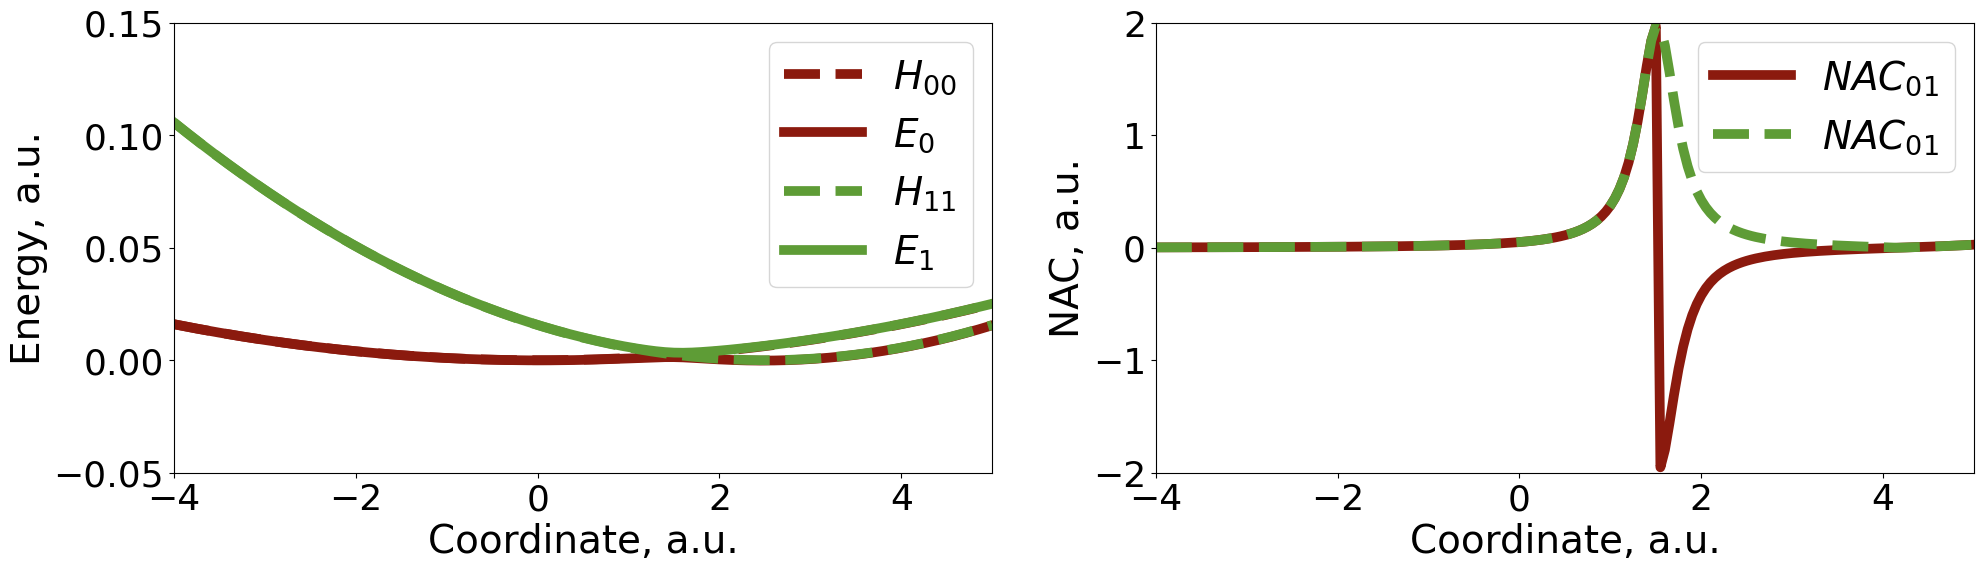

In [14]:
# SC Holstein
plot_params.update( { "xlim":[-4, 5], "ylim":[-0.01*5, 0.03*5], "ylim2":[-2, 2], "show_nac_abs":1 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params1 ], [0,1], -4.0, 5.0, 0.05, plot_params)

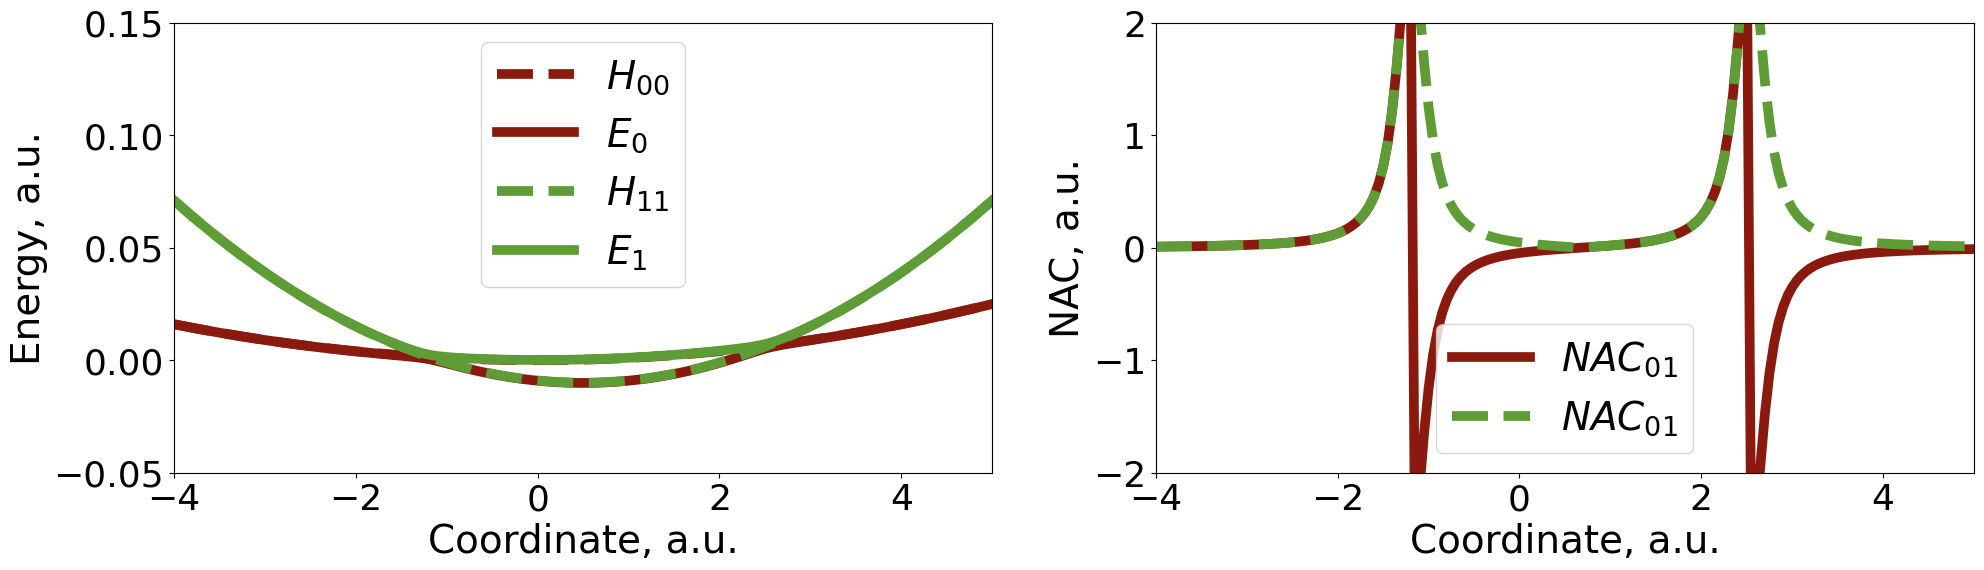

In [15]:
# DC Holstein
plot_params.update( { "xlim":[-4, 5], "ylim":[-0.01*5, 0.03*5], "ylim2":[-2, 2], "show_nac_abs":1 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params2 ], [0,1], -4.0, 5.0, 0.05, plot_params)

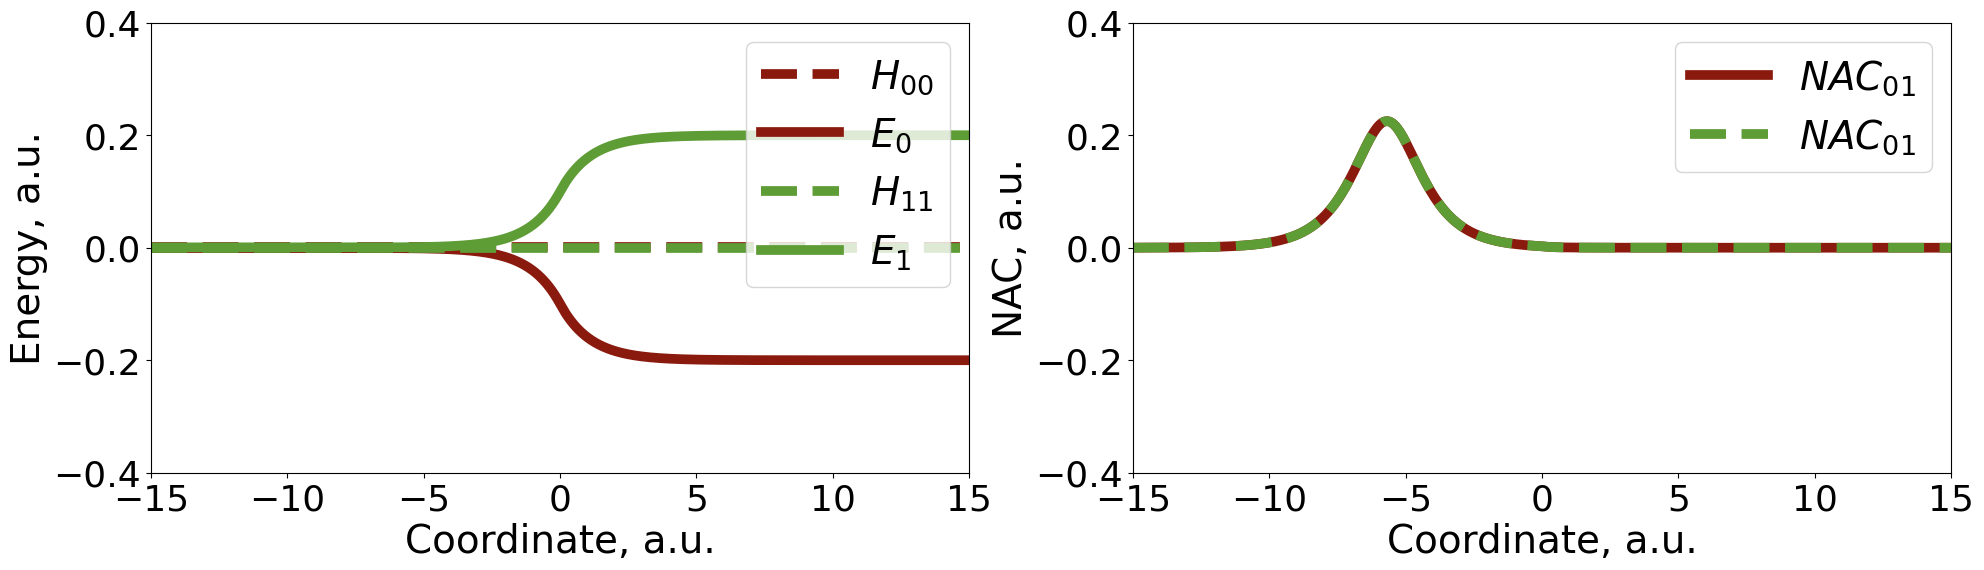

In [16]:
# ECWR
plot_params.update( { "xlim":[-15.0, 15.0], "ylim":[-0.4, 0.4], "ylim2":[-0.4, 0.4], "show_nac_abs":1 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params3 ], [0,1], -15.0, 30.0, 0.05, plot_params)

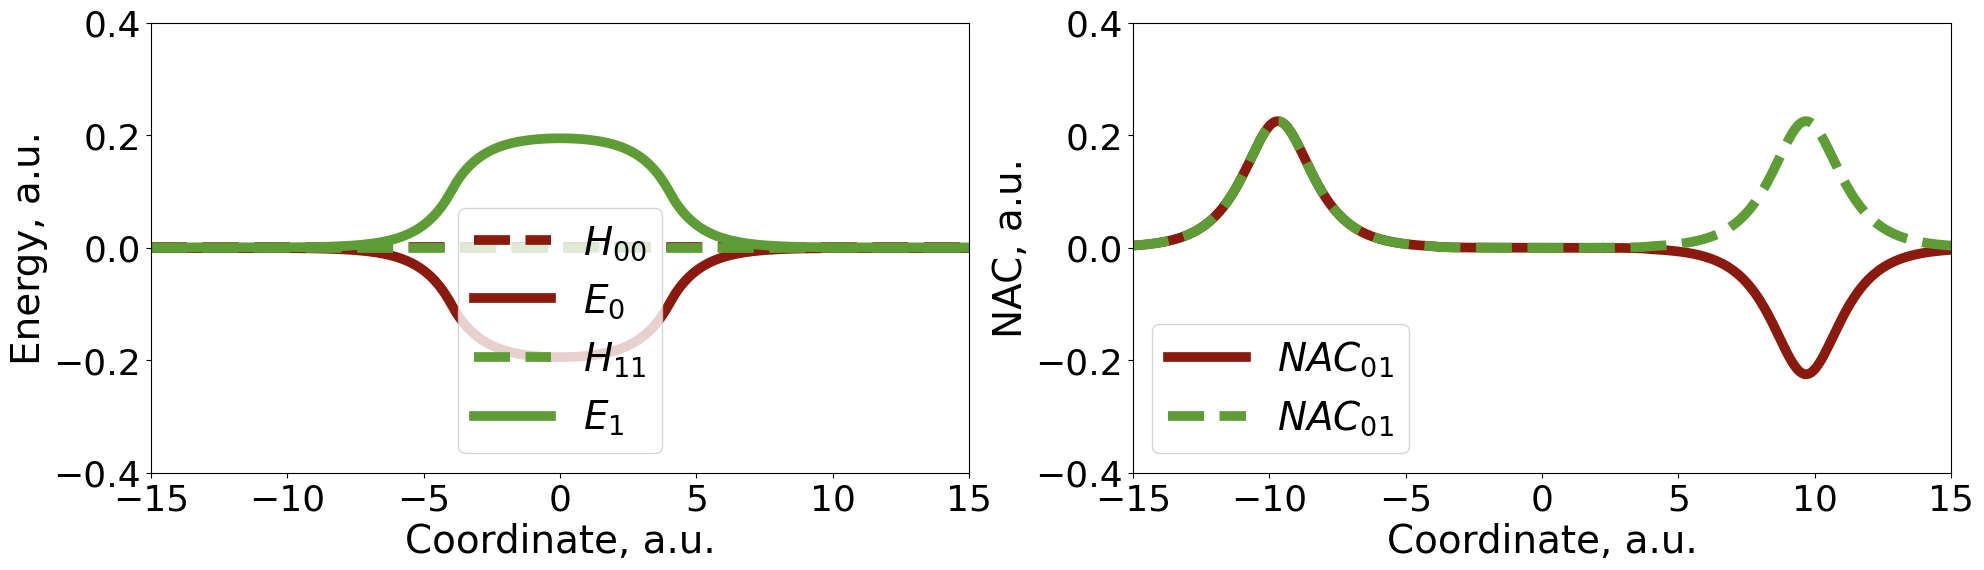

In [17]:
# DAG
plot_params.update( { "xlim":[-15.0, 15.0], "ylim":[-0.4, 0.4], "ylim2":[-0.4, 0.4], "show_nac_abs":1 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params4 ], [0,1], -15.0, 30.0, 0.05, plot_params)

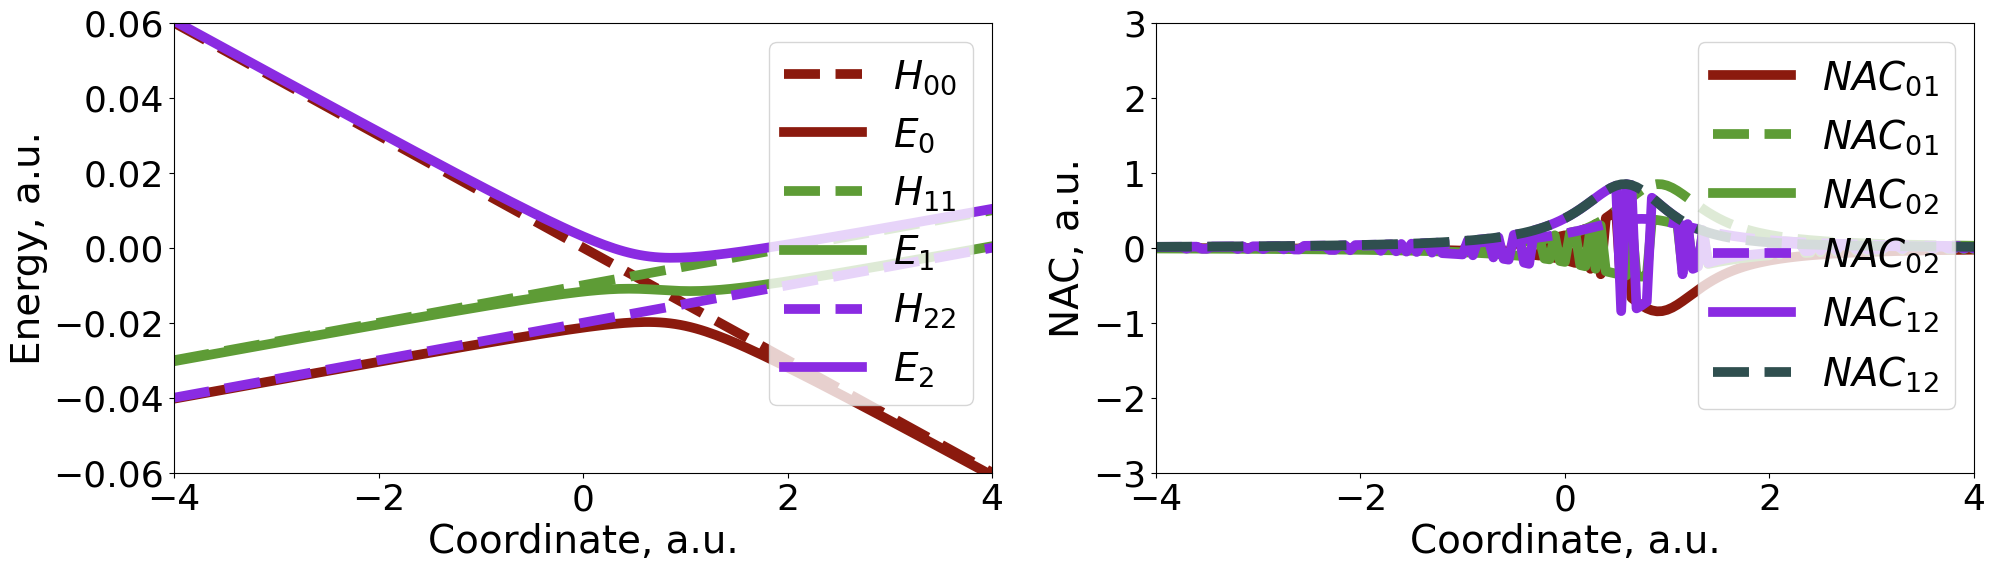

In [18]:
# Esch-Levine
plot_params.update( { "xlim":[-4, 4], "ylim":[-0.06, 0.06], "ylim2":[-3, 3], "show_nac_abs":1 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params5 ], [0,1,2], -4.0, 8.0, 0.05, plot_params)

## 4. Choosing the Nonadiabatic Dynamics Methodology 
<a name="4"></a>[Back to TOC](#TOC)

In this section, we go over parameters to set up a computational methodology. 

Let's start with the simulation-specific parameters:

* `nsteps` -  how many steps of dynamics to compute
* `nstaj` - how many trajectories to use
* `nstates` - the number of states
* `dt:1` - nuclear integration timestep in a.u. of time
* `num_electronic_substeps` - do multiple steps of electronic integration per nuclear step
* `isNBRA` and `is_nbra` - is set to `1`, will turn on some simplifications and optimization for NBRA type of calculations. Here, we are doing the non-NBRA case
* `progress_frequency:0.1` - printing out a message evry `nsteps x 0.1` steps
* `which_adi_states` - properties of which adiabatic states to save
* `which_dia_states` - properties of which diabatic states to save
* `mem_output_level:4` - how much data to save into the hdf5 output files. This is the most intensive output, usually needed only for some special cases (extra-analysis, debugging, new methods, demonstration like htis, etc.)
* `properties_to_save` - list of properties to be computed on the fly and saved into hdf5 output file.

In [6]:
# For setting nsteps
list_nsteps = []
for i in range(len(all_model_params)):
    if all_model_params[i]["model"] == 1: #Holstein
        list_nsteps.append(8000)
    elif all_model_params[i]["model"] == 2: #ECR
        list_nsteps.append(4000)
    elif all_model_params[i]["model"] == 3: #DAG
        list_nsteps.append(3000)
    elif all_model_params[i]["model"] == 4: #Esch-Levine
        list_nsteps.append(8000)

In [7]:
NSTATES = model_params["nstates"]
#list_nsteps[model_indx]
dyn_general = { "nsteps":list_nsteps[model_indx], "ntraj":100, "nstates":NSTATES,
                "dt":1.0, "num_electronic_substeps":1, "isNBRA":0, "is_nbra":0,
                "progress_frequency":0.1, "which_adi_states":range(NSTATES), "which_dia_states":range(NSTATES),      
                "mem_output_level":5,
                "properties_to_save":[ "timestep", "time", "q", "p", "f", "Cadi", "Cdia", "Epot_ave", "Ekin_ave", "Etot_ave",
                "states", "se_pop_adi", "se_pop_dia", "sh_pop_adi", "dc1_adi"],
                "prefix":"adiabatic_md", "prefix2":"adiabatic_md"
              }

Now, it is time to select the type of calculations we want to do. Keep in mind that some options are related to each other, so usually one would need to correlate the choices. For methods based on surface hopping, default options are used for frustrated hops and how to rescale momenta on hops.

In [8]:
#################################
# Give the recipe above an index
method_indx = 3
#################################

if method_indx == 0:
    shxf.load(dyn_general)  # SHXF
elif method_indx == 1:
    mqcxf.load(dyn_general)  # MQCXF
elif method_indx == 2:
    mfxf.load(dyn_general)  # MFXF 
elif method_indx == 3:
    fssh.load(dyn_general)  # FSSH
elif method_indx == 4:
    sdm.load(dyn_general)  # SDM with default EDC parameters
elif method_indx == 5:
    bcsh.load(dyn_general)  # BCSH
    
map_methods = {"SHXF":0, "MQCXF":1, "MFXF":2, "FSSH":3, "SDM":4, "BCSH":5}

In [9]:
#Update properties to save in the case of XF-based methods
if method_indx in [0]:
    dyn_general["properties_to_save"] += ["p_quant", "VP", "q_aux", "p_aux", "nab_phase", "wp_width"]
elif method_indx in [1,2]:
    dyn_general["properties_to_save"] += ["p_quant", "VP", "f_xf", "q_aux", "p_aux", "nab_phase", "wp_width"]  

Set the rest of algorithms for the XF methods.

In [10]:
#####################################  
# wave-packet width approximations
param_indx = 0
#####################################  

WP_W = MATRIX(1,1)
if method_indx in [0,1,2]:
    # The fixed-width approximation
    if param_indx == 0:
        WP_W.set(0,0,0.3)
        dyn_general.update({"use_td_width": 0, "wp_width": WP_W})
    
    elif param_indx == 1:
        WP_W.set(0,0,0.1)
        dyn_general.update({"use_td_width": 0, "wp_width": WP_W})

    # The free-particle Gaussian wave packet approximation
    elif param_indx == 2:
        WP_V = MATRIX(1,1)
        WP_W.set(0,0,0.3); WP_V.set(0,0,0.0004) 
        dyn_general.update({"use_td_width": 1, "wp_width": WP_W, "wp_v": WP_V})

    # The Schwartz scheme
    elif param_indx == 3:
        WP_W.set(0,0,1.0) 
        dyn_general.update({"use_td_width": 2, "wp_width": WP_W})

    elif param_indx == 4:
        WP_W.set(0,0,4.0) 
        dyn_general.update({"use_td_width": 2, "wp_width": WP_W})
    
    # The Subotnik scheme
    elif param_indx == 5: 
        dyn_general.update({"use_td_width": 3})


In [11]:
# turning-point algorithm
variant_indx = 0

if method_indx in [0,1,2]:
    if variant_indx == 0:
        dyn_general.update({"project_out_aux": 1, "tp_algo": 1})
    if variant_indx == 1:
        dyn_general.update({"project_out_aux": 1, "tp_algo": 0})
    if variant_indx == 2:
        dyn_general.update({"project_out_aux": 0, "tp_algo": 1})
    if variant_indx == 3:
        dyn_general.update({"project_out_aux": 0, "tp_algo": 0})

## 5. Choosing initial conditions: Nuclear and Electronic
<a name="5"></a>[Back to TOC](#TOC)

The setup of the parameters below is rather intuitive:

* `ndof` - number of nuclear degrees of freedom
* `q` - nuclear coordinates, should be of length `ndof`
* `p` - nuclear momenta, should be of length `ndof`
* `mass` - nuclear masses, should be of length `ndof`
* `force_constant` - should be of length `ndof`; this is the force constant of the harmonic potential that defines the width of the Gaussian wavepacket (that is the ground-state solution for such potential)
* `init_type` - how to sample (or not) momenta and coordinates

For electronic variables:
* `ndia` - the number of diabatic states
* `nadi` - the number of adiabatic states
* `rep` - representation in which we initialize the electronic variables:
  - 0 - diabatic wfc;
  - 1 - adiabatic wfc;
  - 2 - diabatic density matrix;
  - 3 - adiabatic density matrix;
* `istates` - the populations of all `rep` states, should be of length `nadi`
* `init_type` - how to sample amplitudes

In [12]:
#*********************** This is for the initial condition type **************************
#============== How nuclear DOFs are initialized =================
#icond_nucl = 0  # Coords and momenta are set exactly to the given value
#icond_nucl = 1  # Coords are set, momenta are sampled
#icond_nucl = 2  # Coords are sampled, momenta are set
icond_nucl = 3  # Both coords and momenta are sampled

nucl_params = { "ndof":1, "mass":[2000.0], "force_constant":[0.01], "init_type":icond_nucl }

#============= How electronic DOFs are initialized ==================
#icond_elec = 2  # amplitudes all have the same phase
icond_elec = 3  # amplitudes gain random phase 

#============= Also select the representation ========================
# rep = 0 # diabatic wfc
rep = 1 # adiabatic wfc

istates = []
for i in range(NSTATES):
    istates.append(0.0)    
    
elec_params = {"verbosity":2, "init_dm_type":0,
               "ndia":NSTATES, "nadi":NSTATES, 
               "rep":rep, "init_type":icond_elec, "istates":istates
              }

#******************** This is for specific values in initial conditions *******************
#####################################
# Select a specific initial condition
icond_indx = 0
#####################################    

if model_indx==0: # Holstein model
    if icond_indx==0:
        nucl_params["q"] = [-4.0]; nucl_params["p"] = [0.0]
        elec_params["istates"][0] = 1.0          
    elif icond_indx==1:
        nucl_params["q"] = [-1.0]
        elec_params["istates"][1] = 1.0 
elif model_indx==1: # Holstein model
    if icond_indx==0:
        nucl_params["q"] = [-4.0]; nucl_params["p"] = [0.0]
        elec_params["istates"][0] = 1.0
    elif icond_indx==1:
        nucl_params["q"] = [-3.0]; nucl_params["p"] = [0.0]
        elec_params["istates"][1] = 1.0
elif model_indx==2: # ECWR
    if icond_indx==0:
        nucl_params["q"] = [-15.0]; nucl_params["p"] = [25.0]
        elec_params["istates"][0] = 1.0
elif model_indx==3: # DAG
    if icond_indx==0:
        nucl_params["q"] = [-20.0]; nucl_params["p"] = [20.0]
        elec_params["istates"][0] = 1.0
elif model_indx==4: # Esch-Levine 3-level
    if icond_indx==0:
        nucl_params["q"] = [-1.0]; nucl_params["p"] = [10.0]
        elec_params["istates"][2] = 1.0

## 6. Running the calculations
<a name="6"></a>[Back to TOC](#TOC)

In [18]:
%%time
dyn_params = dict(dyn_general)
dyn_params.update({ "prefix":F"model{model_indx}-method{method_indx}-param{param_indx}-var{variant_indx}-icond{icond_indx}", 
                    "prefix2":F"model{model_indx}-method{method_indx}-param{param_indx}-var{variant_indx}-icond{icond_indx}" })

print(F"Computing model{model_indx}-method{method_indx}-param{param_indx}-var{variant_indx}-icond{icond_indx}")    

rnd = Random()
res = tsh_dynamics.generic_recipe(dyn_params, compute_model, model_params, elec_params, nucl_params, rnd)

Computing model2-method3-param5-var0-icond0
Active states (adiabatic)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Initial adiabatic populations
[1.0, 0.0]
Initial diabatic populations
[1.61456482133515e-08, 0.9999999838543523]
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting repr

 step= 800
 step= 1200
 step= 1600
 step= 2000
 step= 2400
 step= 2800
 step= 3200
 step= 3600
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'q', 'p', 'f', 'Cadi', 'Cdia', 'Epot_ave', 'Ekin_ave', 'Etot_ave', 'states', 'se_pop_adi', 'se_pop_dia', 'sh_pop_adi', 'dc1_adi']
keywords =  ['timestep', 'time', 'q', 'p', 'f', 'Cadi', 'Cdia', 'Epot_ave', 'Ekin_ave', 'Etot_ave', 'states', 'se_pop_adi', 'se_pop_dia', 'sh_pop_adi', 'dc1_adi']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'states', 'se_pop_adi', 'se_pop_dia', 'sh_pop_adi', 'q', 'p', 'f', 'Cadi', 'Cdia', 'dc1_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named q/data
Saving the dataset named p/data
Saving the dataset named f/data
Saving the dataset named Cadi/data
Saving the dataset named Cdia/data
Saving the dataset named Epot_ave/data
Saving the dataset named Ekin_ave/data
Saving the dataset named Etot_ave/data
Saving the dataset named s

## 7. Plotting the results
<a name="7"></a>[Back to TOC](#TOC)

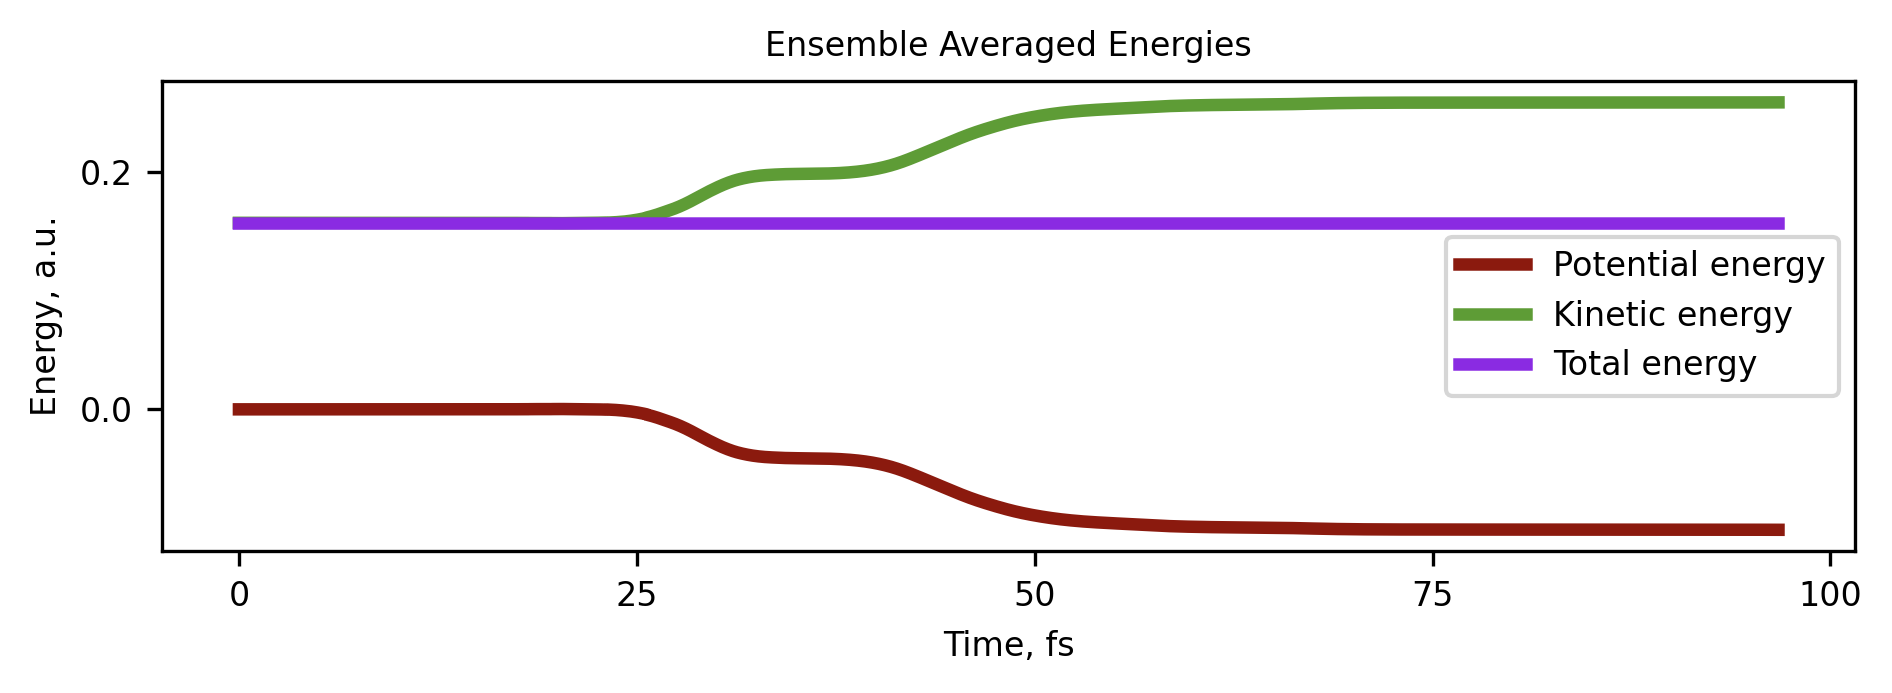

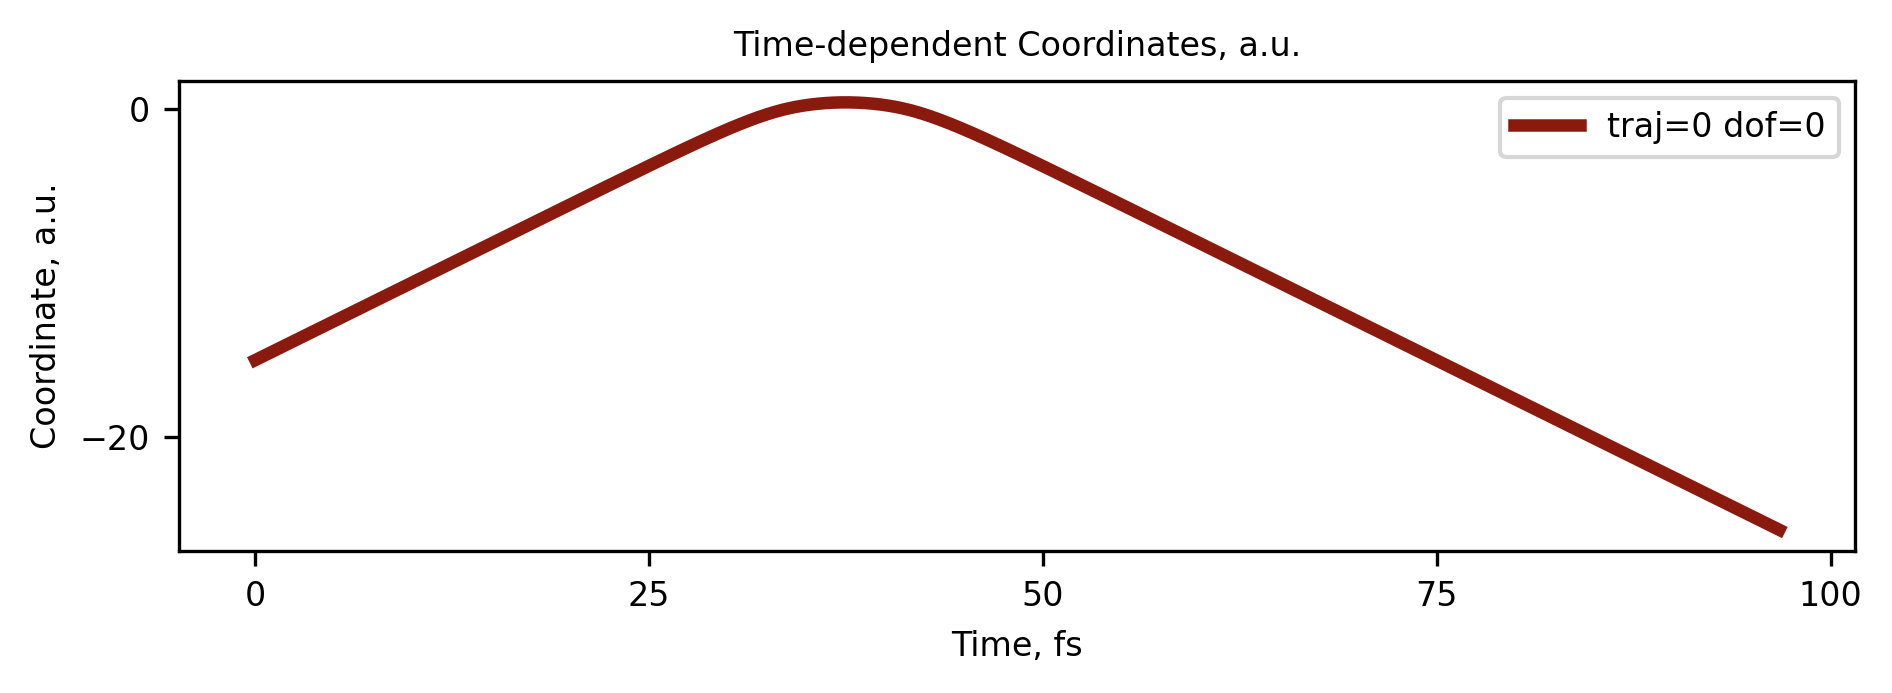

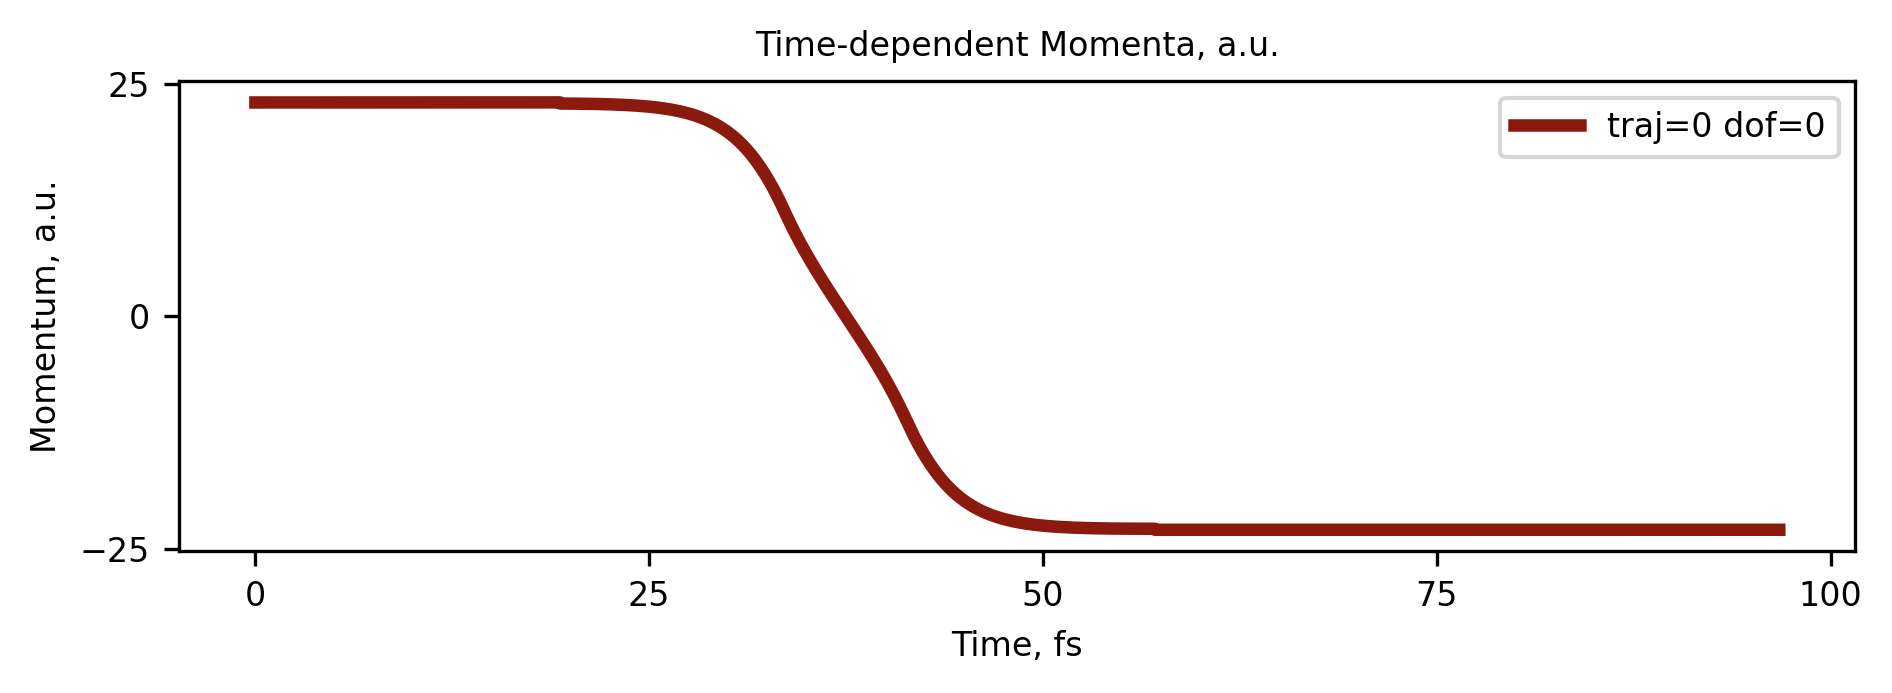

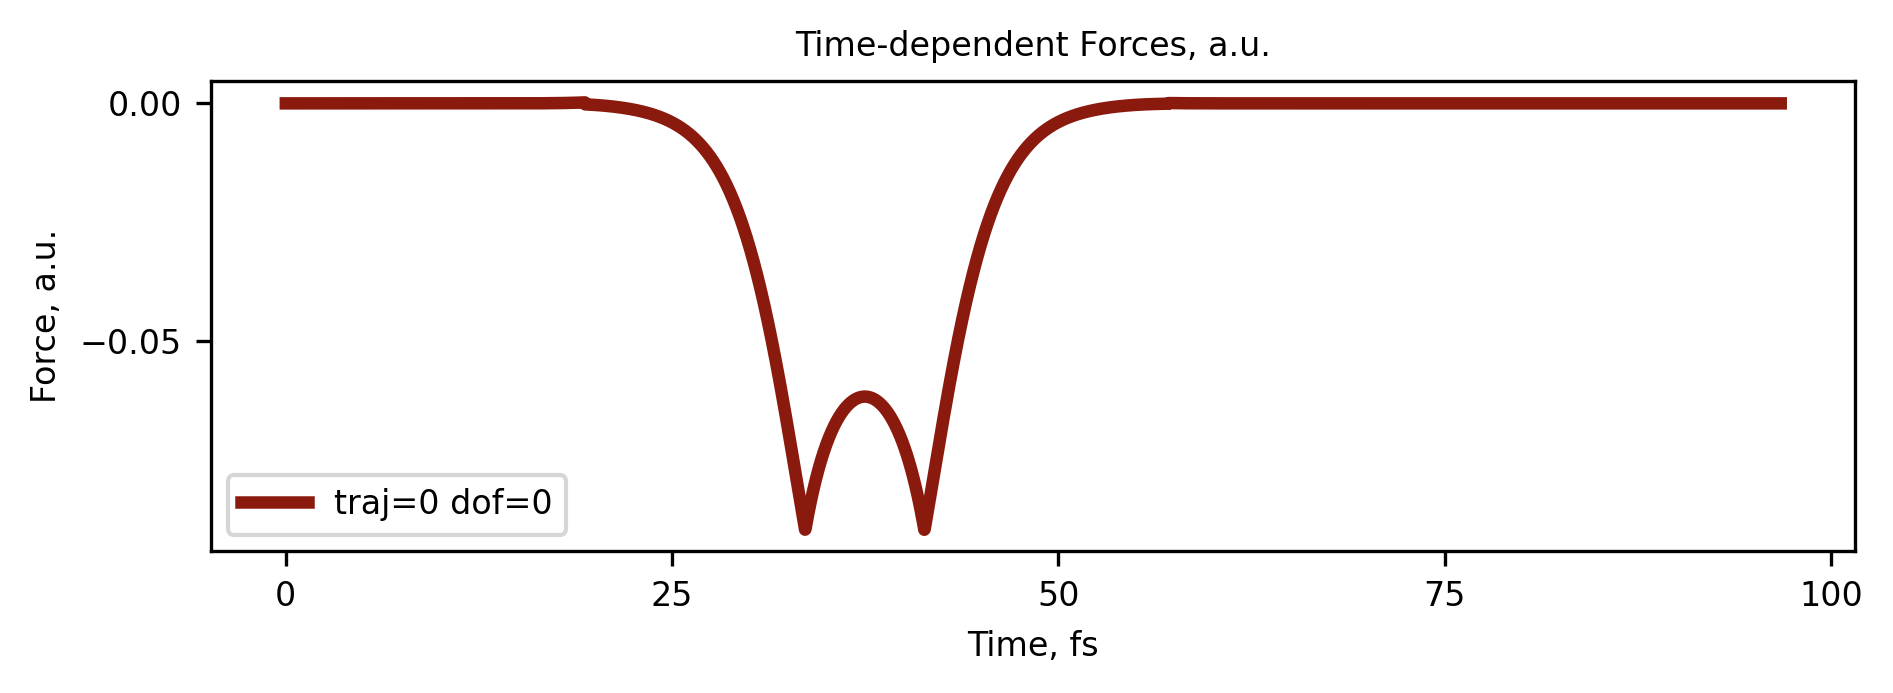

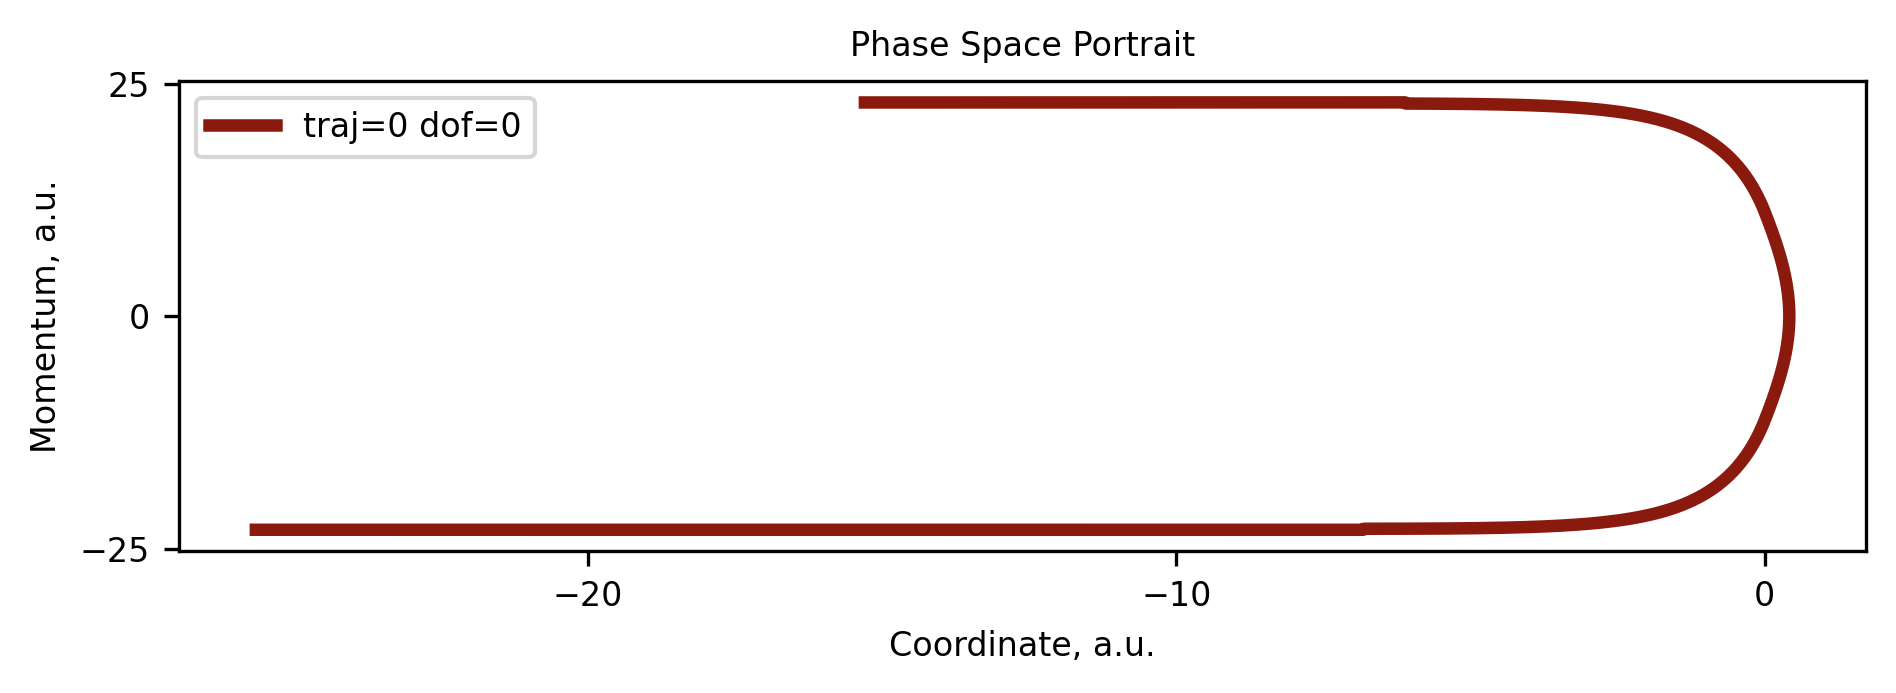

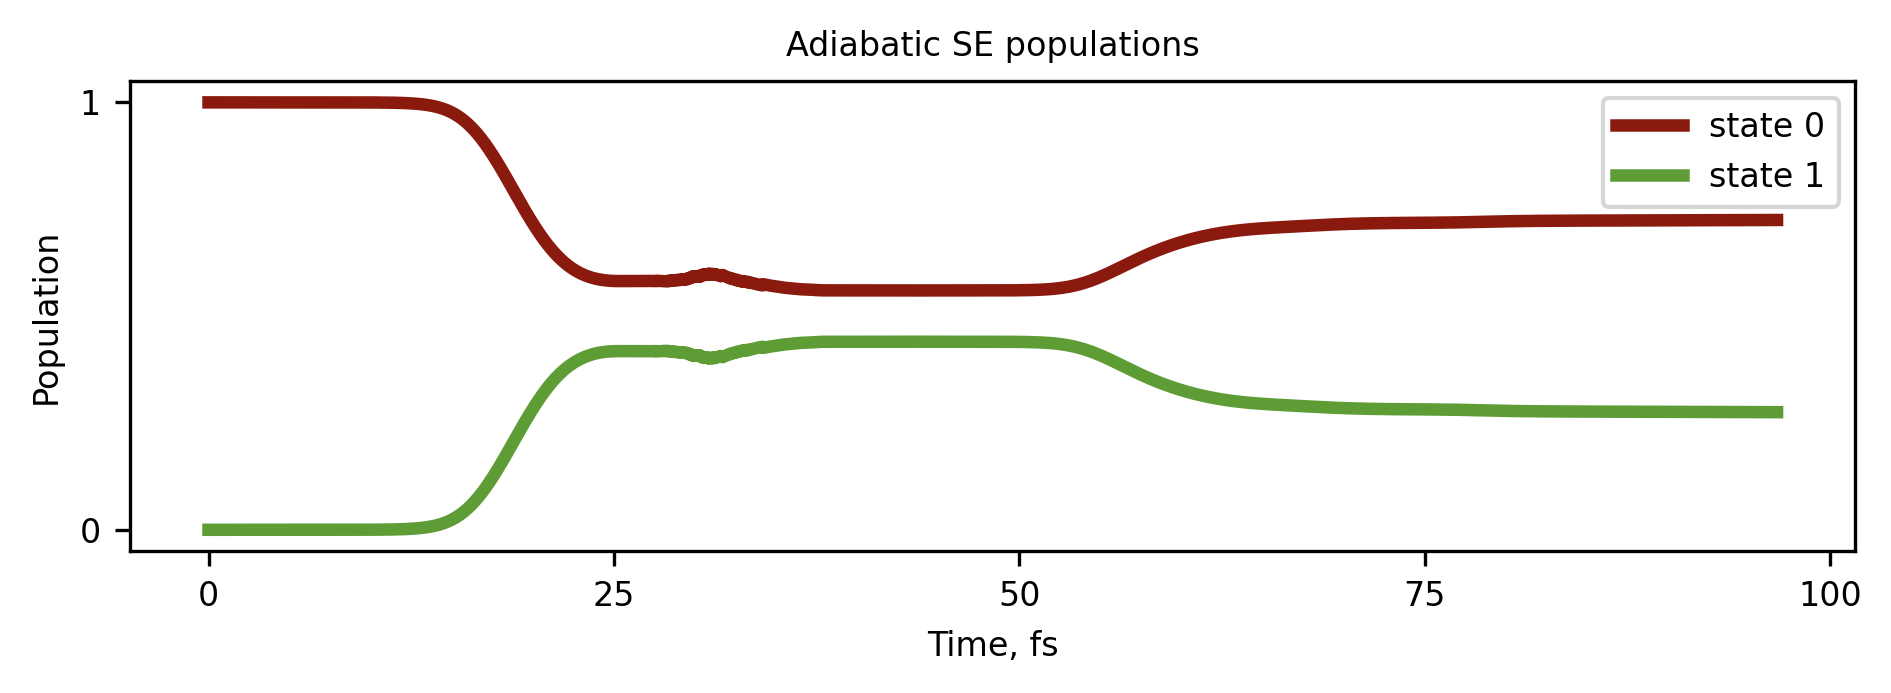

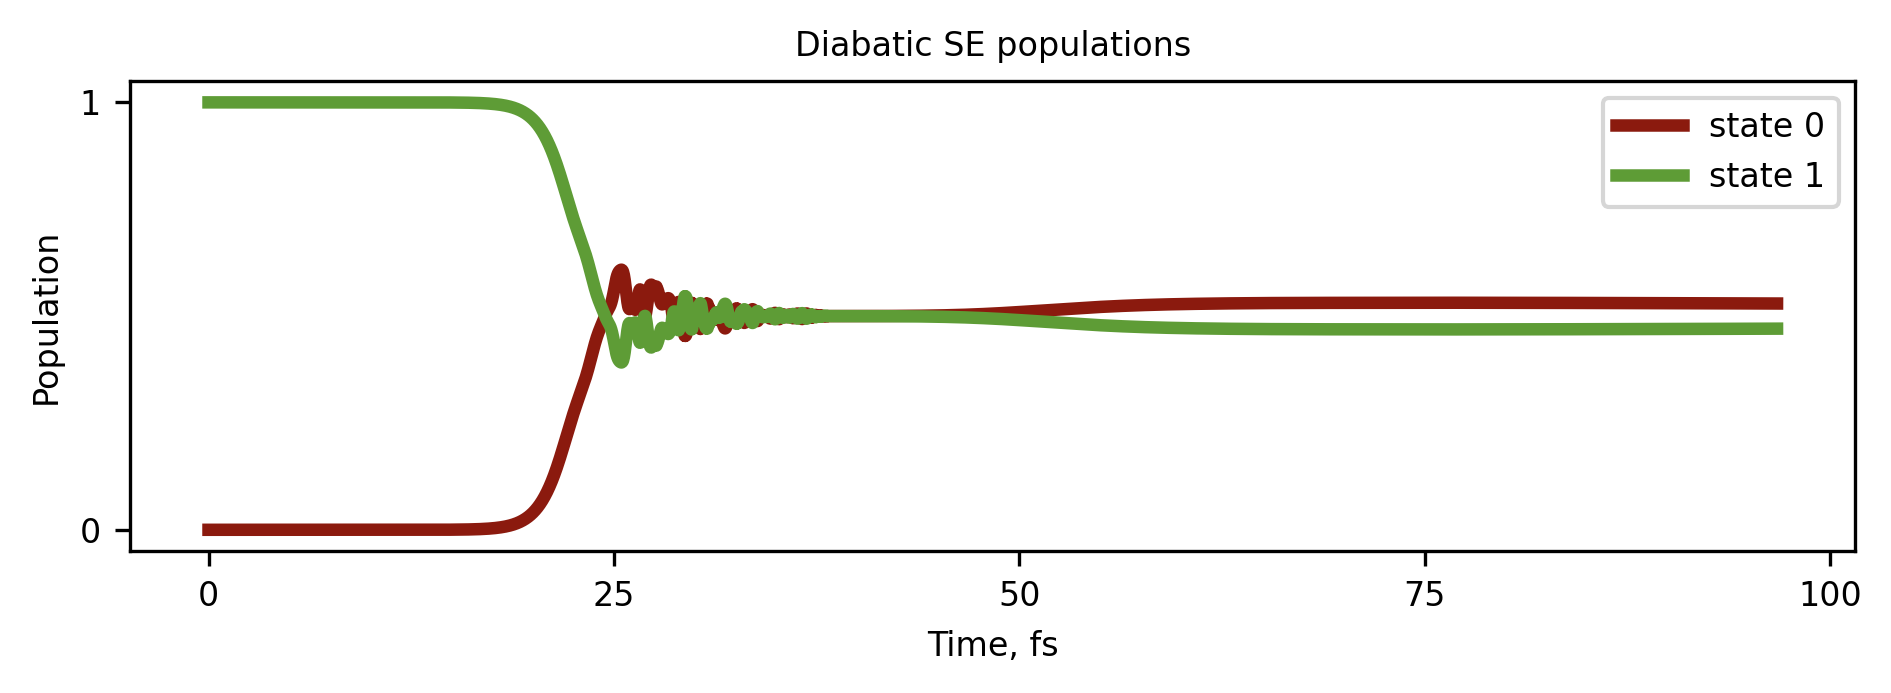

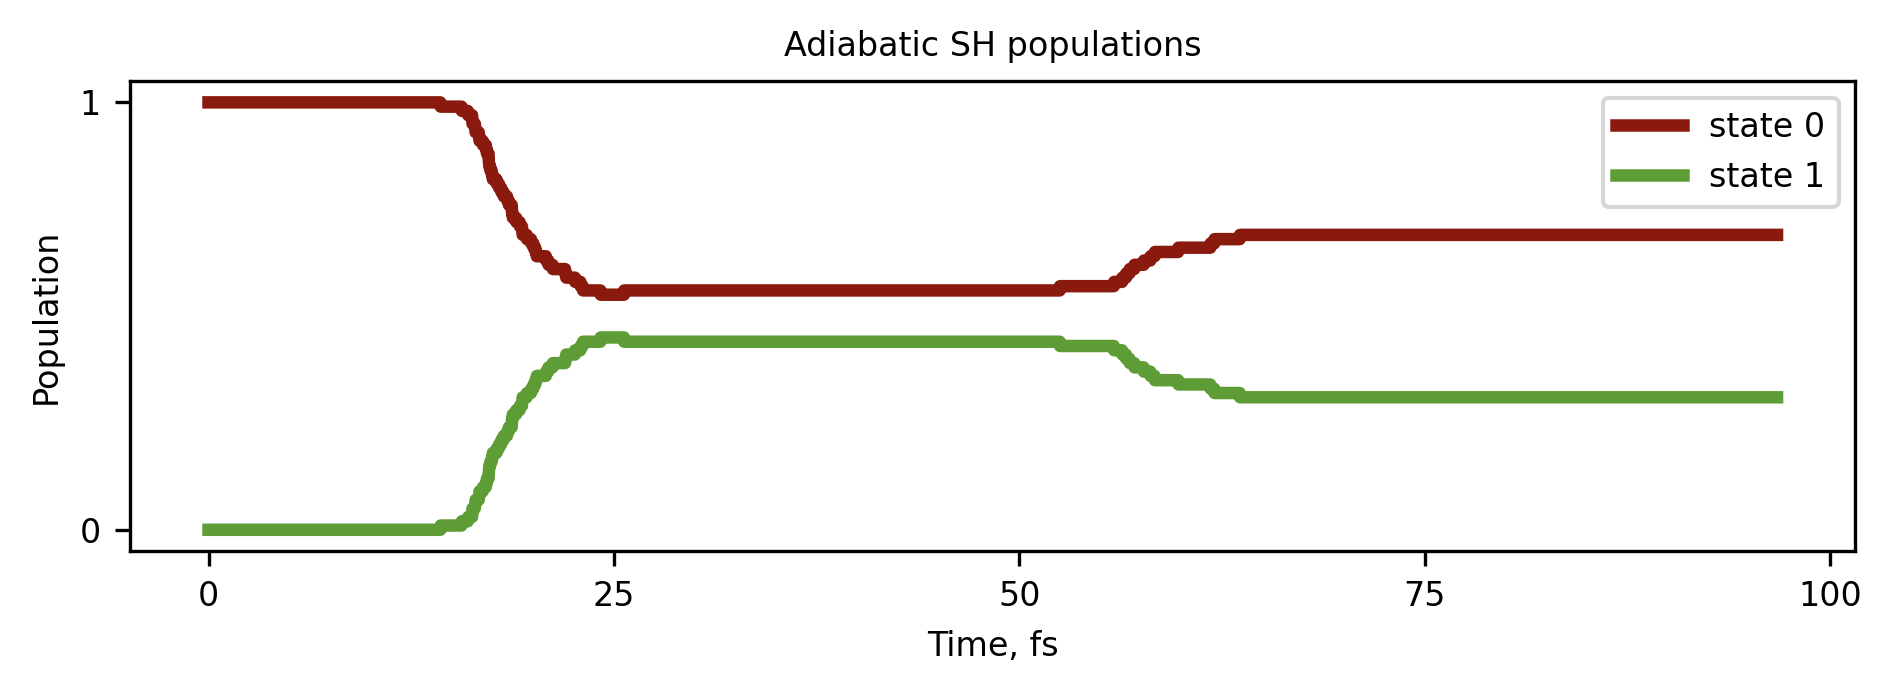

In [19]:
#============ Plotting ==================
pref = F"model{model_indx}-method{method_indx}-param{param_indx}-var{variant_indx}-icond{icond_indx}"

plot_params = { "prefix":pref, "filename":"mem_data.hdf", "output_level":3,
                "which_trajectories":[0], "which_dofs":[0], "which_adi_states":list(range(NSTATES)), 
                "which_dia_states":list(range(NSTATES)), 
                "frameon":True, "linewidth":3, "dpi":300,
                "axes_label_fontsize":(8,8), "legend_fontsize":8, "axes_fontsize":(8,8), "title_fontsize":8,
                "what_to_plot":["coordinates", "momenta",  "forces", "energies", "phase_space", "se_pop_adi",
                                "se_pop_dia", "sh_pop_adi" ], 
                "which_energies":["potential", "kinetic", "total"],
                "save_figures":1, "do_show":1
              }

#"what_to_plot":["coordinates", "momenta",  "forces", "energies", "phase_space", "se_pop_adi",
#                                "se_pop_dia", "sh_pop_adi", "traj_resolved_adiabatic_ham", "traj_resolved_diabatic_ham", 
#                                "time_overlaps", "basis_transform"
#                               ], 

tsh_dynamics_plot.plot_dynamics(plot_params)

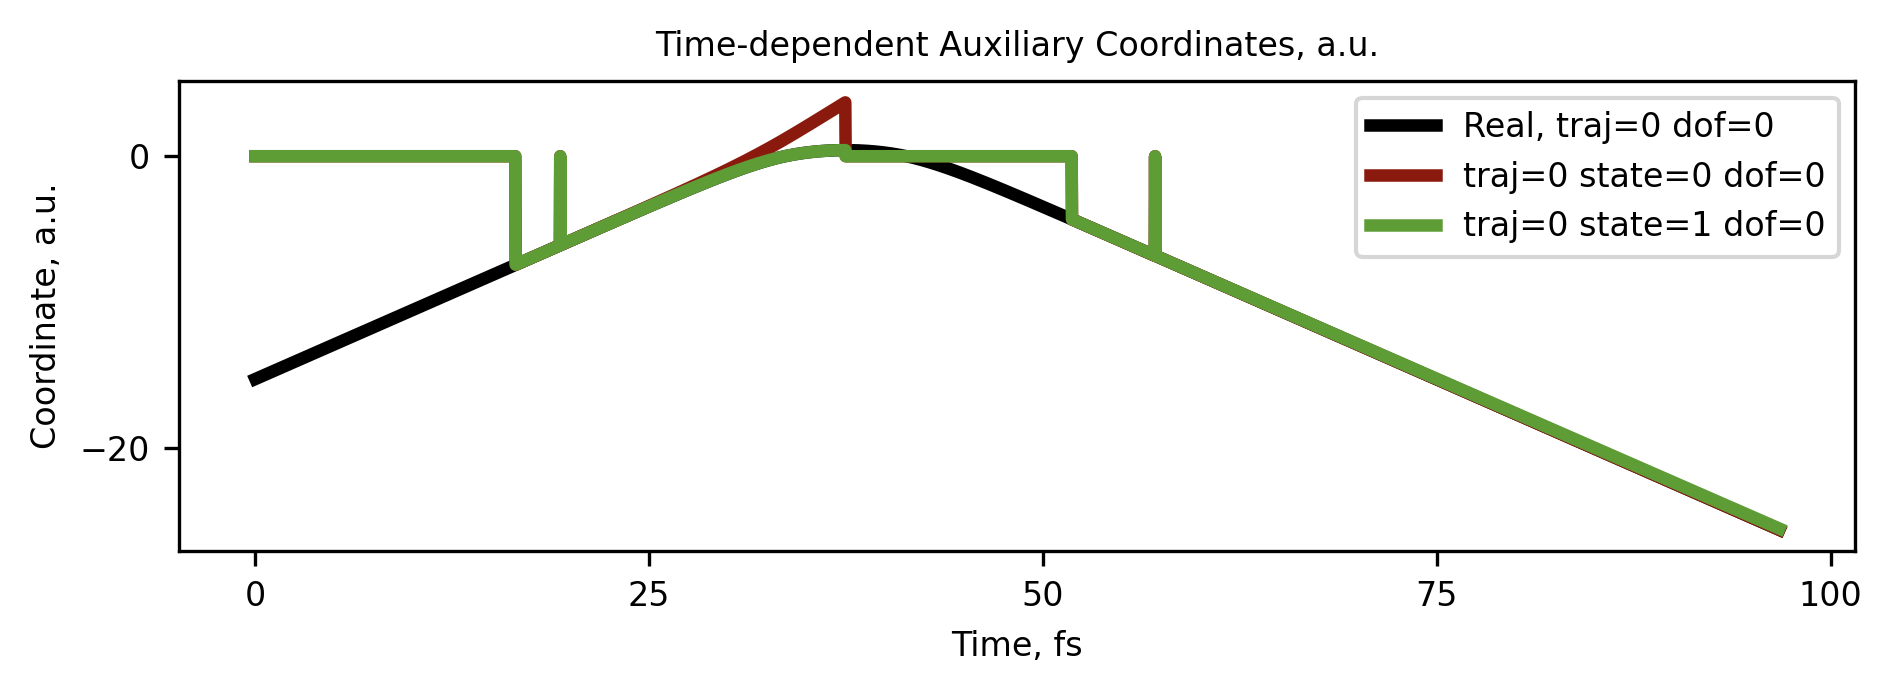

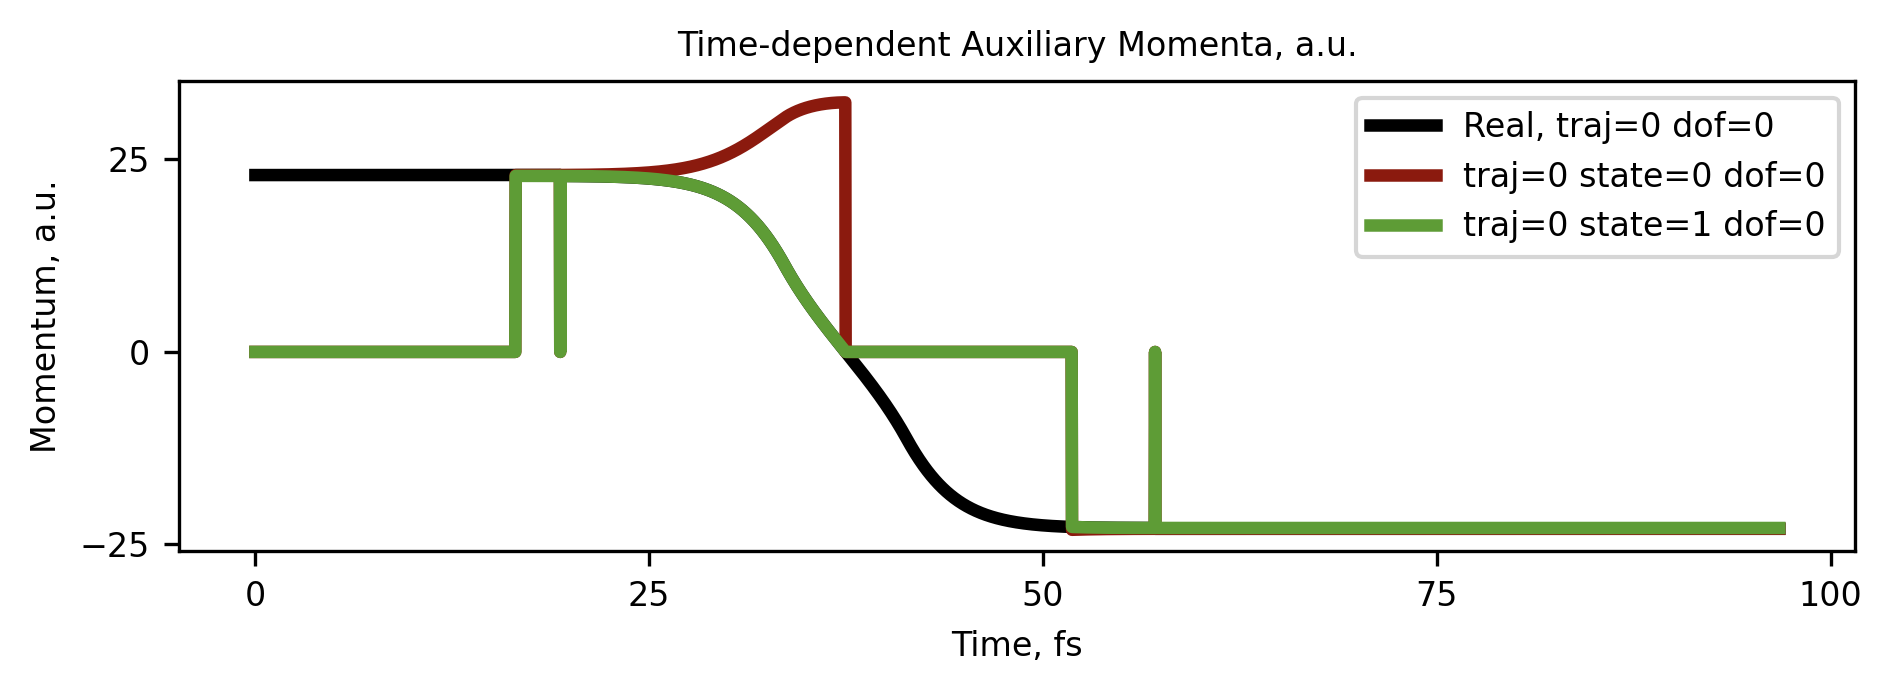

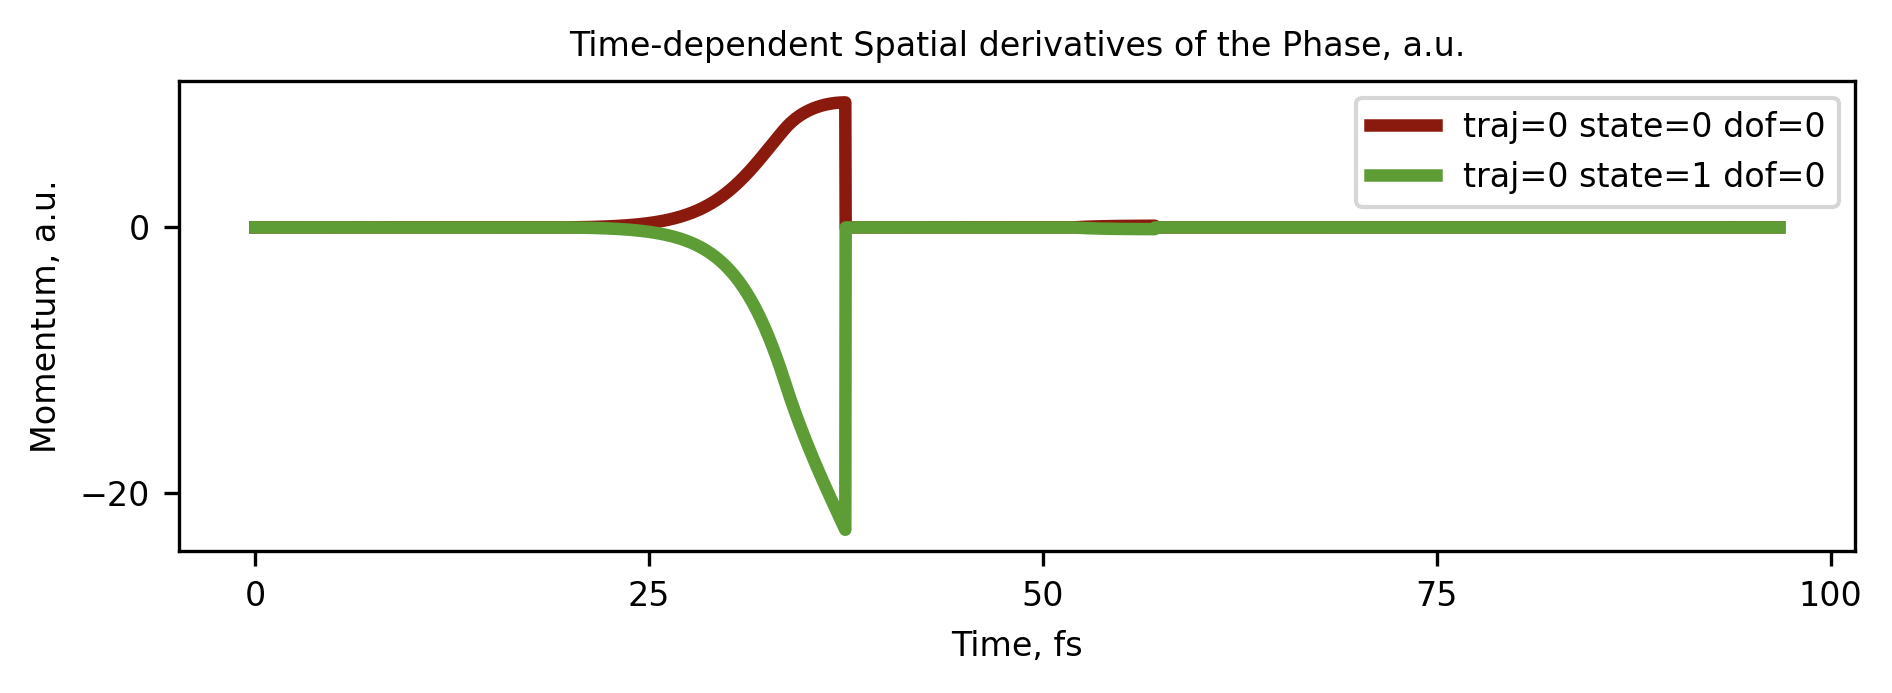

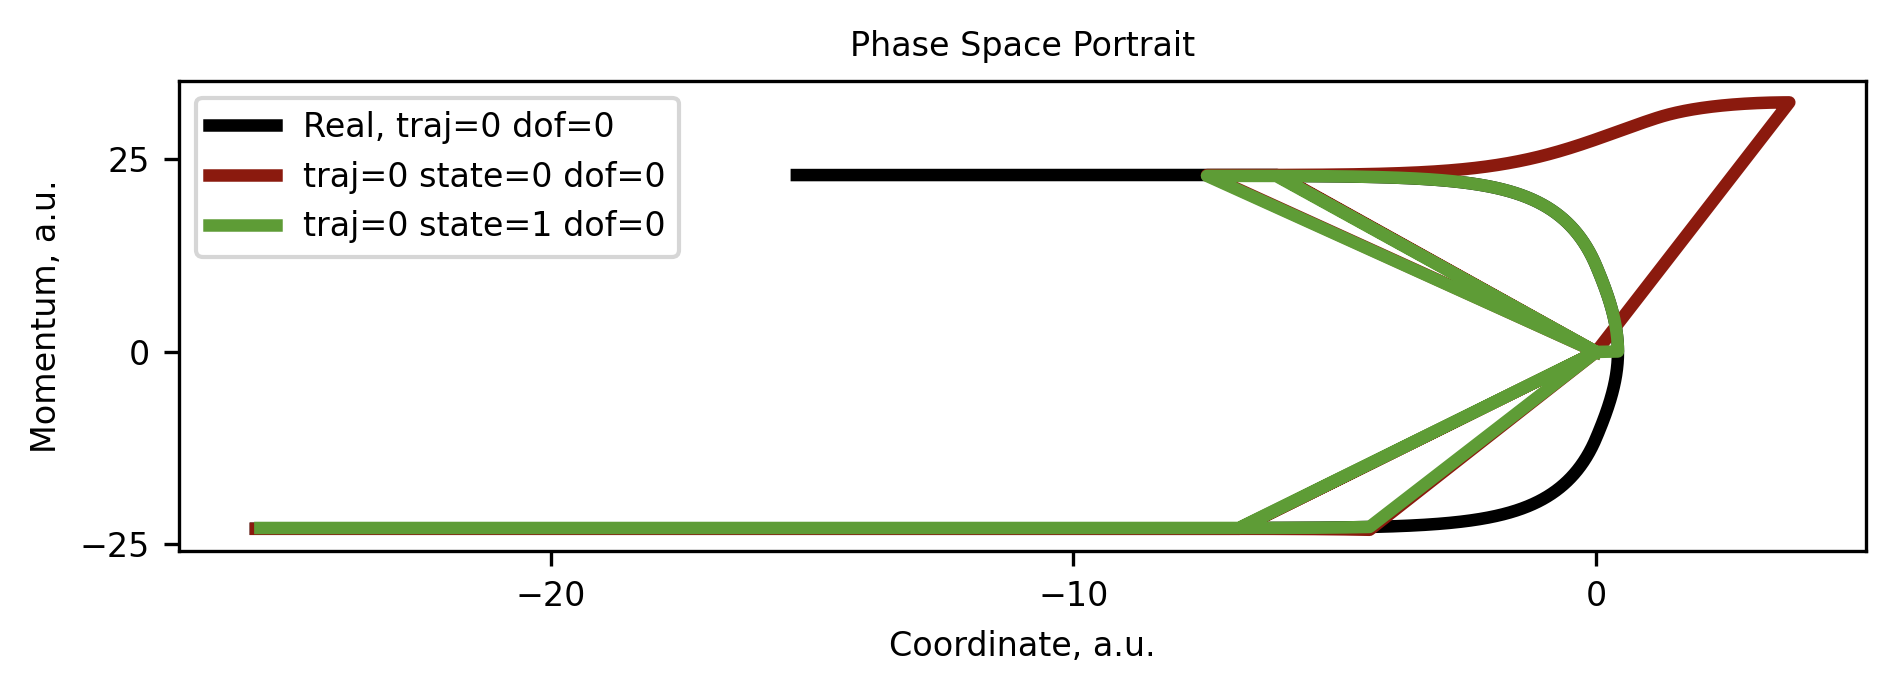

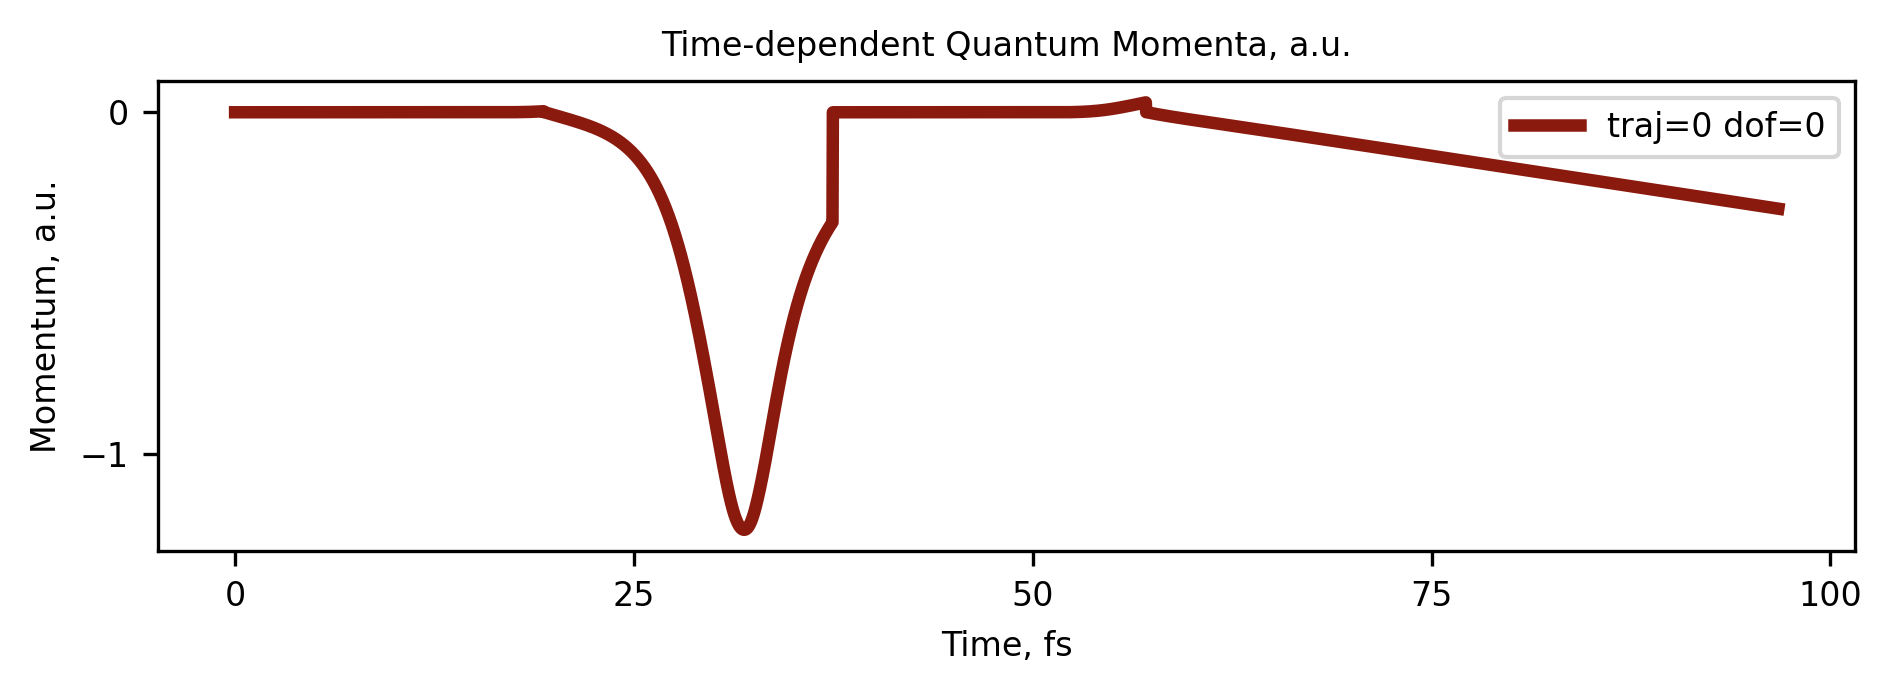

In [20]:
if method_indx in [0]:
    plot_params["what_to_plot"] = ["q_aux", "p_aux", "nab_phase", "phase_space_aux", "p_quant"]
elif method_indx in [1, 2]:
    plot_params["what_to_plot"] = ["q_aux", "p_aux", "nab_phase", "phase_space_aux", "p_quant", "VP", "f_xf"]

if method_indx in [0,1,2]:
    tsh_dynamics_plot.plot_dynamics_xf(plot_params)

### Exercise 1
Explore various model systems using the XF methods and other conventional methods.

### Exercise 2
Use different width schemes by changing `param_indx`.

### Exercise 3
One can change the turning-point algorithm by changing `variant_indx`. How do auxiliary variables behave according to that?

### Exercise 4
How does the total energy profile in MQCXF change according to the turning-point algorithm?

### Exercise 5
In the MQCXF calculations for the given models, the XF force is parallel to the quantum momentum. Explain why.

### Exercise 6
Estimate the reflectance and transmittance in the scattering models such as ECWR, DAG by counting the trajectories under various initial momenta.

## 8. Comparison with quantum dynamics
<a name="8"></a>[Back to TOC](#TOC)

We conduct the quantum dynamics as the benchmark.

In the quantum dynamics in the discrete variable representation (DVR) using Libra, the total wave function $|\Psi(\mathbf{R},t)\rangle$ is expressed in the nuclear grid space and orthonormal electronic basis $\{ |j_{\mathbf{R}}\rangle \}$.
$$ |\Psi(\mathbf{R},t)\rangle=\sum_{j}\psi_{j}(\mathbf{R},t)|j_{\mathbf{R}}\rangle. $$
Within XF, the discretized wave function can be written as
$$ |\Psi(\mathbf{R},t)\rangle=\chi(\mathbf{R},t)|\Phi_{\mathbf{R}}(t)\rangle $$
under the partial normalization condition, $\forall \mathbf{R} \forall t \:  \langle \Phi_{\mathbf{R}}(t) | \Phi_{\mathbf{R}}(t) \rangle = 1$. Equating the DVR and XF ansatzs within the basis expansion $|\Phi_{\mathbf{R}}(t)\rangle=\sum_{j}C_{j}(\mathbf{R},t)|j_{\mathbf{R}}\rangle$, one obtains $|\chi(\mathbf{R},t)|^{2}=\sum_{j}|\psi_{j}(\mathbf{R},t)|^{2}$ and $C_{j}(\mathbf{R},t)\chi(\mathbf{R},t)=\psi_{j}(\mathbf{R},t)$. 

The density matrix $\rho_{jk}(\mathbf{R},t)$ between electronic basis states is defined as $\rho_{jk}(\mathbf{R},t)=C_{j}(\mathbf{R},t)C_{k}^{\ast}(\mathbf{R},t)$. Eventually, the reduced density matrix elements are used for the descriptor of population $\langle \rho_{jj}(t) \rangle$ and coherence $\langle |\rho_{jk}(t)|^{2} \rangle$.
$$ \langle \rho_{jj}(t) \rangle = \int |\psi_{j}(\mathbf{R},t)|^{2} d\mathbf{R} \approx \frac{1}{N_{traj}}\sum_{I}^{N_{traj}} \rho_{jj}^{I}(t)$$
$$ \langle |\rho_{jk}(t)|^{2} \rangle = \int \frac{|\psi_{j}(\mathbf{R},t)|^{2}|\psi_{k}(\mathbf{R},t)|^{2}}{\sum_{n}|\psi_{n}(\mathbf{R},t)|^{2}} d\mathbf{R} \approx \frac{1}{N_{traj}}\sum_{I}^{N_{traj}} \rho_{jj}^{I}(t)\rho_{kk}^{I}(t). $$
Here, the rightmost expressions are the approximated forms in the MQC dynamics, and $\rho_{jk}^{I}$ is the electronic density matrix on the $I$th trajectory.

### 8.1 Run the quantum dynamics
<a name="8.1"></a>[Back to TOC](#TOC)

We define the range of the grid space, \[rmin, rmax\]. The space should be sufficiently large to capture the wave packet dynamics fully.

In [13]:
if model_indx in [0,1]: # Holstein
    rmin, rmax = -25.0, 25.0
elif model_indx in [2,3]: # ECWR, DAG
    rmin, rmax = -35.0, 70.0
elif model_indx==4: # Esch-Levine
    rmin, rmax = -100.0, 300.0
    
# For setting the initial state
state_indx = [i for i in range(len(elec_params["istates"])) if elec_params["istates"][i] > 0.5][0]

In [14]:
def potential(q, params):
    full_id = Py2Cpp_int([0,0]) 
    
    return compute_model(q, params, full_id)

In [15]:
exact_params = { "nsteps":int(list_nsteps[model_indx]), "dt":1.0, "progress_frequency":1/50,
                 "rmin":[rmin], "rmax":[rmax], "dx":[0.025], "nstates":model_params["nstates"],
                  "x0":nucl_params["q"], "p0":nucl_params["p"], "istate":[1,state_indx], "masses":[2000.0], "k":[0.01],
                  "integrator":"SOFT",
                  "wfc_prefix":F"wfc{model_indx}", "wfcr_params":[0,0,1], "wfcr_rep":1, 
                  "wfcr_states":[x for x in range(all_model_params[model_indx]["nstates"])],
                  "wfck_params":[0,0,1], "wfck_rep":1, "wfck_states":[x for x in range(all_model_params[model_indx]["nstates"])],
                  "mem_output_level":0, "txt_output_level":0, "txt2_output_level":0, "hdf5_output_level":3, 
                  "properties_to_save":[ "timestep", "time", "Epot_dia", "Ekin_dia", "Etot_dia",
                                         "Epot_adi", "Ekin_adi", "Etot_adi", "norm_dia", "norm_adi",
                                         "pop_dia", "pop_adi", "q_dia", "q_adi", "p_dia", "p_adi",
                                         "coherence_adi"],
                  "prefix":F"exact-model{model_indx}-icond{icond_indx}", "prefix2":F"exact-model{model_indx}-icond{icond_indx}",
                  "use_compression":0, "compression_level":[0, 0, 0]
               }

In [16]:
wfc = dvr.init_wfc(exact_params, potential, model_params)
savers = dvr_save.init_tsh_savers(exact_params, model_params, exact_params["nsteps"], wfc)
dvr.run_dynamics(wfc, exact_params, model_params, savers)

 === In constructor ===
 == in init_numbers ==
Dimension 0 has 8192 grid points
Grid size is calculated
Minimal wavevector along dimension 0 is -20
 == done with init_numbers ==
 == in allocate ==
nstates = 2
ndof = 1
Dimension 0 has 8192 grid points
 == done with allocate ==
In init_grids, ndof = 1
Norm (dia) =  0.9999999999999997
Norm (adi) =  0.9999999999999997
Ekin (dia) =  0.1568090169975428
Ekin (adi) =  0.8028621670111853
Epot (dia) =  -0.0006000000187727459
Epot (adi) =  -0.0006000000187727461
HDF5 saver is initialized...
the datasets that can be saved are: ['timestep', 'time', 'Epot_dia', 'Ekin_dia', 'Etot_dia', 'Epot_adi', 'Ekin_adi', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'p_dia', 'p_adi', 'coherence_adi']
 step= 0
 step= 80
 step= 160
 step= 240
 step= 320
 step= 400
 step= 480
 step= 560
 step= 640
 step= 720
 step= 800
 step= 880
 step= 960
 step= 1040
 step= 1120
 step= 1200
 step= 1280
 step= 1360
 step= 1440
 step= 1520
 step= 1600


### 8.2 Plot the population and coherence indicators <a name="S8.2"></a>
<a name="8.2"></a>[Back to TOC](#TOC)

Now, we can compare the results from the MQC and quantum dynamics. From the previous calculations, we can extract saved data using appropriate keywords. 

In [27]:
# Compare the population
def compare_pop(_model_indx, _param_indx=0, _variant_indx=0, _icond_indx=0, which_methods=["SHXF", "MQCXF", "FSSH"]):
    nst = all_model_params[_model_indx]["nstates"]
    
    # Extract populations from the DVR dynamics
    fn_QD = F"exact-model{_model_indx}-icond{_icond_indx}/data.hdf"
    
    with h5py.File(fn_QD, 'r') as f:
        ts = np.array(f["time/data"][:])
        P_QD = np.array(f["pop_adi/data"][:, :, 0]) # nsteps x nst array
    
    # Extract populations from the MQC dynamics
    P_methods = []
    for name_methods in which_methods:
        _method_indx = map_methods[name_methods]
        fn_MQC = F"model{_model_indx}-method{_method_indx}-param{_param_indx}-var{_variant_indx}-icond{_icond_indx}/mem_data.hdf"
        
        with h5py.File(fn_MQC, 'r') as f:
            P_tmp = np.array(f["se_pop_adi/data"][:, :]) # nsteps x nst array
        
        P_methods.append(P_tmp)
    
    # Plotting
    fig, ax = plt.subplots(nst, figsize=(10,6))
    
    for ist in range(nst):
        ax[ist].set_xlabel("Time, fs")
        ax[ist].set_ylabel(rF"$\rho_{ist}{{}}_{ist}$")
    
        ax[ist].plot(ts/41.0, P_QD[:,ist], label="QD", linewidth=5, color = "black")
        
        for i, name_methods in enumerate(which_methods):
            ax[ist].plot(ts/41.0, P_methods[i][:,ist], label=name_methods, linewidth=1, marker="o", markevery=int(ts.shape[0]/20)
                , color = colors[clrs_index[i]])
    
    ax[0].legend(fontsize=25)
    
    fig.tight_layout()
    

In [28]:
# Compare the coherence
def compare_coh(_model_indx, _param_indx=0, _variant_indx=0, _icond_indx=0, which_methods=["SHXF", "MQCXF", "FSSH"]):
    nst = all_model_params[_model_indx]["nstates"]
    npair = int(nst*(nst-1)/2)
    
    # Extract coherences from the DVR dynamics
    fn_QD = F"exact-model{_model_indx}-icond{_icond_indx}/data.hdf"
    
    with h5py.File(fn_QD, 'r') as f:
        ts = np.array(f["time/data"][:])
        C_QD = np.array(f["coherence_adi/data"][:, :, :])
    
    # Extract populations from the MQC dynamics
    C_methods = []
    for name_methods in which_methods:
        _method_indx = map_methods[name_methods]
        fn_MQC = F"model{_model_indx}-method{_method_indx}-param{_param_indx}-var{_variant_indx}-icond{_icond_indx}/mem_data.hdf"
        
        # Extract the coefficients and compute the coherence
        with h5py.File(fn_MQC, "r") as f:
            C_ADI = f["Cadi/data"][:,:,:] # nsteps, ntraj, nstates
        nsteps, ntraj, = C_ADI.shape[:2]
        C_ADI_reshaped = C_ADI.reshape(nsteps, ntraj, nst, 1)
        C_MQC = np.sum(np.abs(C_ADI_reshaped) ** 2 * np.abs(C_ADI_reshaped.transpose(0, 1, 3, 2)) ** 2, axis=1) / ntraj
        
        C_methods.append(C_MQC)
    
    # Plotting
    fig, ax = plt.subplots(npair, figsize=(10,6))
    
    count = -1
    if npair > 1:
        for ist in range(nst):
            for jst in range(nst):
                if(ist>=jst): continue
                count += 1
                ax[count].set_xlabel("Time, fs")
                ax[count].set_ylabel(rF"$\rho_{ist}{{}}_{jst}$")
        
                ax[count].plot(ts/41.0, C_QD[:,ist,jst], label="QD", linewidth=5, color = "black")
            
                for i, name_methods in enumerate(which_methods):
                    ax[count].plot(ts/41.0, C_methods[i][:,ist,jst], label=name_methods, linewidth=1, marker="o", markevery=int(ts.shape[0]/20)
                        , color = colors[clrs_index[i]])
        ax[0].legend(fontsize=25)
    else:
        ax.set_xlabel("Time, fs")
        ax.set_ylabel(rF"$|\rho_{{01}}|^{2}$")
        
        ax.plot(ts/41.0, C_QD[:,0,1], label="QD", linewidth=5, color = "black")
            
        for i, name_methods in enumerate(which_methods):
            ax.plot(ts/41.0, C_methods[i][:,1,0], label=name_methods, linewidth=1, marker="o", markevery=int(ts.shape[0]/20)
                    , color = colors[clrs_index[i]])
        
        ax.legend(fontsize=25)
    
    fig.tight_layout()
    

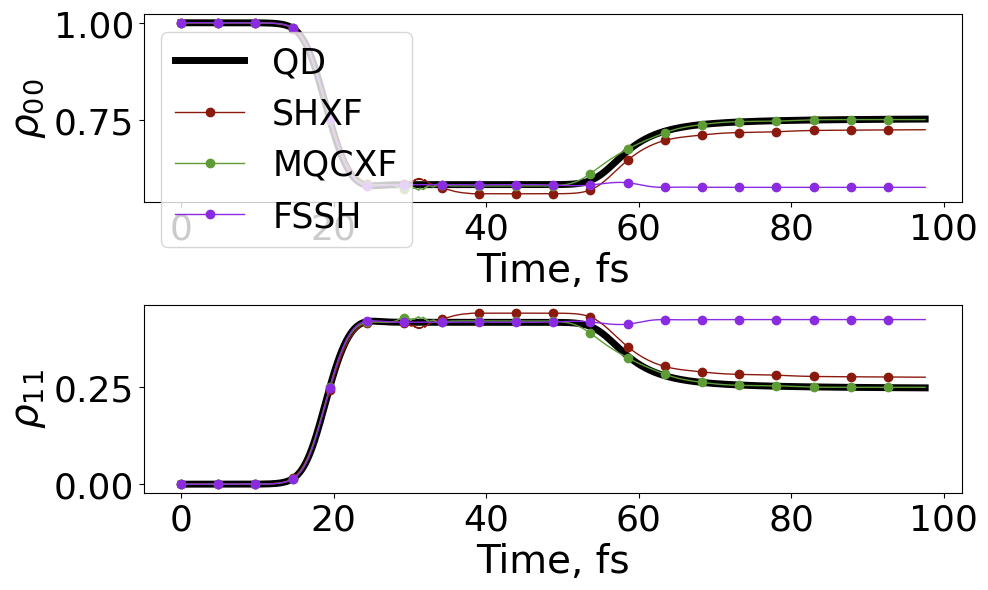

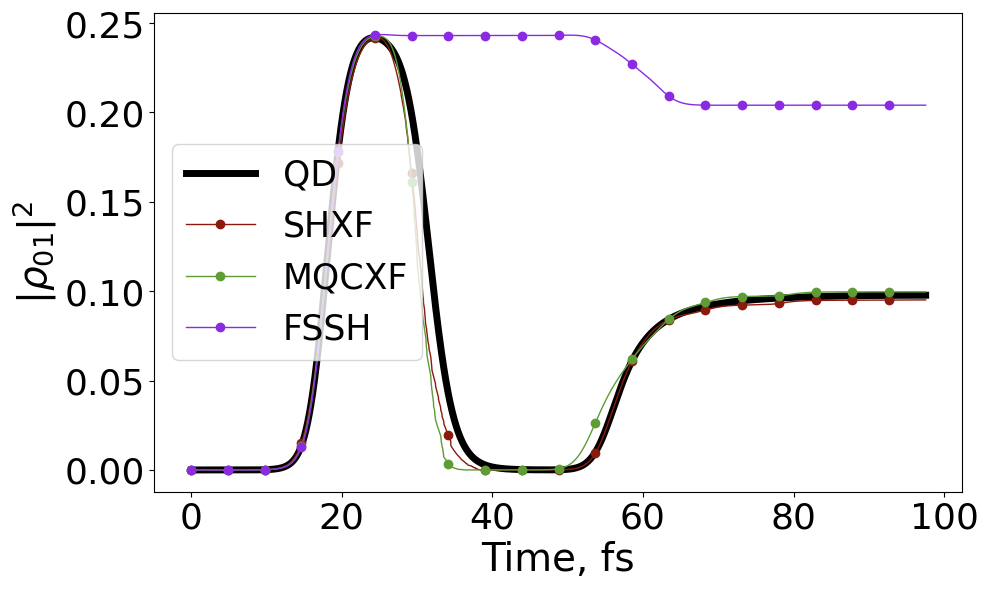

In [29]:
compare_pop(2); compare_coh(2)

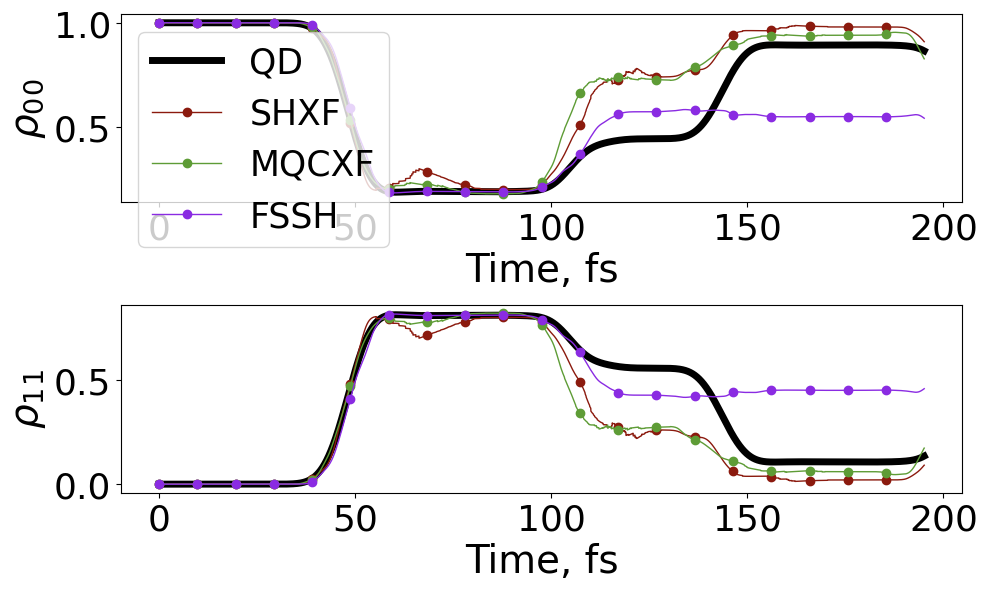

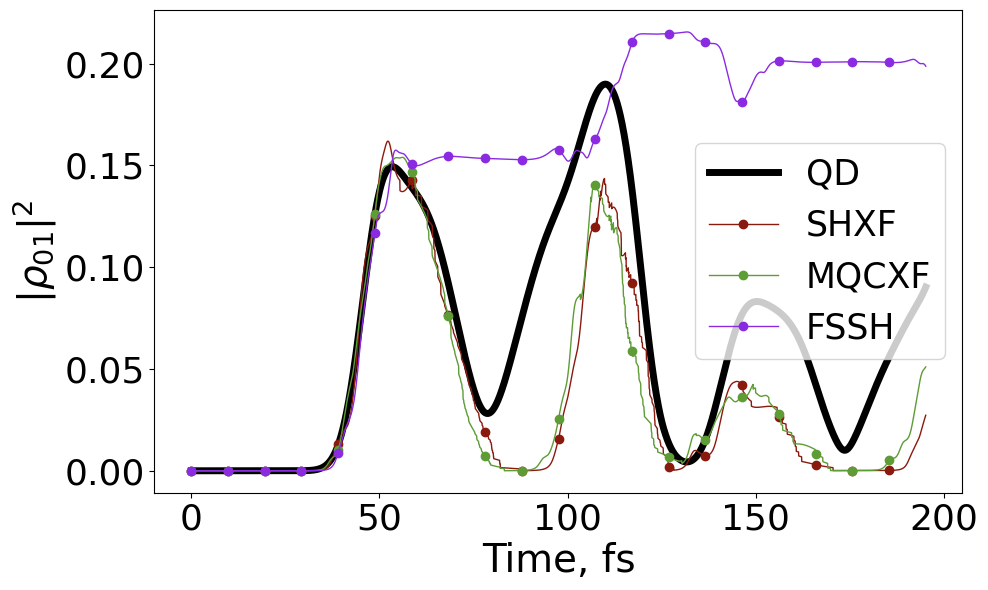

In [30]:
compare_pop(0); compare_coh(0)

### Exercise 7
Derive the expressions for the population and coherence indicators in the quantum and MQC dynamics.

### Exercise 8
Population based on active states is also available in Libra, whose keyword is `"sh_pop_adi"`. Extract and compare this population with that of the quantum dynamics.

### Exercise 9
Extract and compare the average position $\langle R \rangle$ between the quantum and MQC dynamics. The average position from the quantum dynamics can be directly obtained by the keyword `"q_adi"`. On the other hand, in the MQC dynamics, trajectory-resolved positions are saved with the keyword `"q"`.

## 9. Phase-space diagrams
<a name="10"></a>[Back to TOC](#TOC)

Here, we monitor the dynamics in the phase space, while the color of each phase-space point shows the population contribution.

In [35]:
def get_qp_MQC(_model_indx, _method_indx, _param_indx=0, _variant_indx=0, _icond_indx=0):
    fn_MQC = F"model{_model_indx}-method{_method_indx}-param{_param_indx}-var{_variant_indx}-icond{_icond_indx}/mem_data.hdf"
        
    # Extract the coefficients and compute the coherence
    with h5py.File(fn_MQC, "r") as f:
        QS = f["q/data"][:, :, 0] # coordinates
        PS = f["p/data"][:, :, 0] # momenta
        C_ADI = f["Cadi/data"][:,:,:] # coef
    
    return QS, PS, C_ADI

In [67]:
def make_phase_space_movie(_model_indx, _method_indx, _qlim, _plim, _param_indx=0, _variant_indx=0, _icond_indx=0, time_interval=20):
    QS, PS, C_ADI = get_qp_MQC(_model_indx, _method_indx)
    P0 = np.real(C_ADI[:,:,0]*C_ADI[:,:,0].conj())

    cm = clrs.LinearSegmentedColormap.from_list("Custom", [(0.0, colors[clrs_index[1]]), (1.0, colors[clrs_index[0]])])

    ntraj = QS.shape[1]
    interval = time_interval
    frames = int(list_nsteps[_model_indx]/interval)

    fig, ax = plt.subplots(figsize=(7,7))

    def update(i):
        ax.clear()
        ax.set_title(F"t={i*interval/41.0:.2f} fs")
        ax.set_xlabel("Coordindates, a.u.")
        ax.set_ylabel("Momenta, a.u.")
        ax.scatter(QS[i*interval], PS[i*interval], c=P0[i*interval], cmap=cm)
        ax.set_xlim(_qlim)
        ax.set_ylim(_plim)
        
        fig.tight_layout()

    ani = animation.FuncAnimation(fig, update, frames=frames, interval=interval)
    ani.save(F"model{_model_indx}-method{_method_indx}-param{_param_indx}-var{_variant_indx}-icond{_icond_indx}/movie.gif")

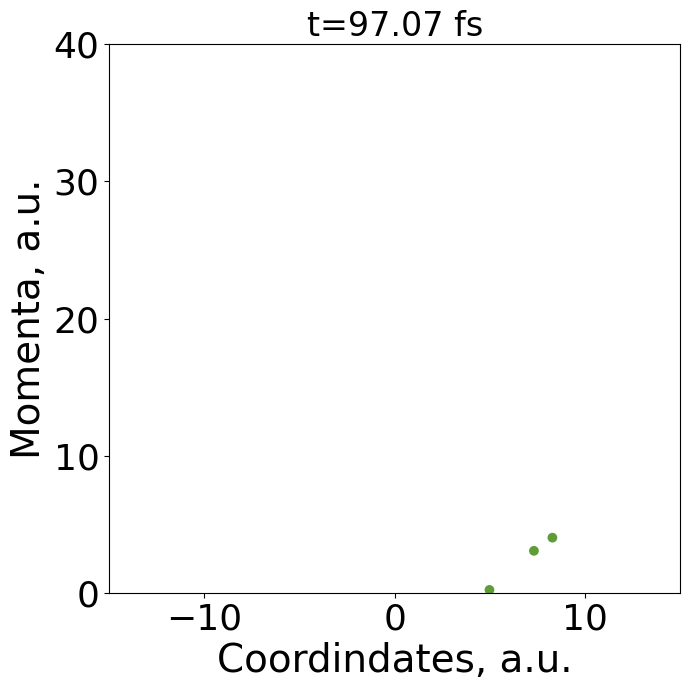

In [68]:
make_phase_space_movie(2,0, [-15,15], [0,40])

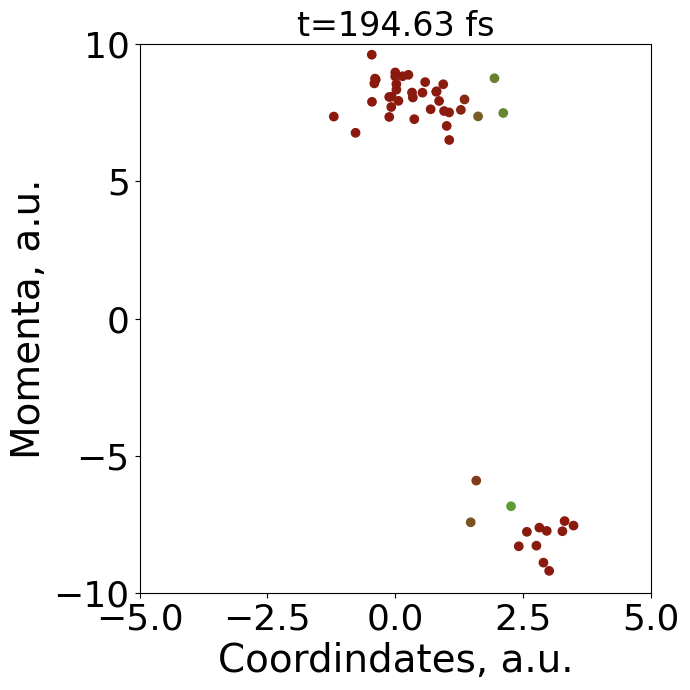

In [69]:
make_phase_space_movie(0,0, [-5,5], [-10,10])

### Exercise 10
Check overcoherence when we do not have a decoherence correction in the MQC dynamics.

## 10. Dynamics snapshots
<a name="9"></a>[Back to TOC](#TOC)

Here, we compare the $\mathbf{R}$-resolved data from the MQC and quantum dynamics through dynamics snapshots. The time-dependent potential energy surface (TDPES) from the quantum dynamics can be obtained by
$$ \langle \Phi_{\mathbf{R}}|\hat{H}_{BO}|\Phi_{\mathbf{R}} \rangle = \frac{\sum_{j}|\psi_{j}(\mathbf{R},t)|^{2}E_{j}(\mathbf{R})}{\sum_{j}|\psi_{j}(\mathbf{R},t)|^{2}}. $$
Through the MQC dynamics, the TDPES can be approximated to $\sum_{j}|C_{j}^{I}|^{2}E_{j}^{I}$ within a given set of classical trajectories $\{\mathbf{R}^{I}(t), \mathbf{P}^{I}(t) \}$ and in the TSH-based methods, an adiabatic-state PES is chosen by the hopping process. Also, the quantum momenta from the quantum dynamics can be computed by replacing the gradient with a simple numerical differentiation.
$$ -i\mathcal{P}_{\nu}(R,t)=-\frac{\partial_{\nu}|\chi(\mathbf{R},t)|^{2} }{2|\chi(\mathbf{R},t)|^{2}}.  $$
Both quantities from the quantum dynamics contains numerical noises where the nuclear density is sparse.

In [27]:
## Collecting adiabatic PES
# Adiabatic surface information
def get_Eadi(_model_indx, q):
    nst = all_model_params[_model_indx]["nstates"]
    res = potential(q, all_model_params[_model_indx])
    H = np.zeros((nst, nst), dtype=complex)
    for i in range(nst):
        for j in range(nst):
            H[i,j] = res.ham_dia.get(i,j)
    E, U = np.linalg.eig(H) 
    idx= np.argsort(E) 
    E = E[idx] 
    U = U[:,idx]

    return E

In [28]:
# Calculate the PES from the model Hamiltonian, the space is from the QD calculation setting
def get_PES(_model_indx, window):
    nst = all_model_params[_model_indx]["nstates"]
    nr = 1000
    dr = (window[1] - window[0])/nr
    rs = [window[0] + dr*i for i in range(nr)]

    Es = []

    q = MATRIX(1,1) # temporary for a nuclear coordinate
    for ir in range(nr):
        val = window[0] + ir*dr
        q.set(0, 0, val)
        E = get_Eadi(_model_indx, q)

        Es.append(E)

    Es = np.array(Es, dtype=np.float64) # nr x nst
    
    return rs, Es

In [30]:
## Collect the time-dependent energies from trajectories
def get_tdPES_MQC(_model_indx, _method_indx, _param_indx=0, _variant_indx=0, _icond_indx=0):
    fn_MQC = F"model{_model_indx}-method{_method_indx}-param{_param_indx}-var{_variant_indx}-icond{_icond_indx}/mem_data.hdf"
        
    # Extract the coefficients and compute the coherence
    with h5py.File(fn_MQC, "r") as f:
        C_ADI = f["Cadi/data"][:,:,:] # coefficients, nsteps, ntraj, nstates
        QS = f["q/data"][:, :, 0] # coordinates
        STATES = f["states/data"][:,:] # active states
        nsteps, ntraj, nst = C_ADI.shape
    
    tdE = np.zeros((nsteps, ntraj))
    q = MATRIX(1,1) # temporary for a nuclear coordinate
    if _method_indx in [1,2]: # Ehrenfest variants
        for istep in range(nsteps):
            for itraj in range(ntraj):
                q.set(0, 0, QS[istep, itraj])
                E = get_Eadi(_model_indx, q)
            
                for ist in range(nst):
                    tdE[istep, itraj] += E[ist]*np.linalg.norm(C_ADI[istep, itraj, ist])**2        
    else: # SH variants
        for istep in range(nsteps):
            for itraj in range(ntraj):
                q.set(0, 0, QS[istep, itraj])
                E = get_Eadi(_model_indx, q)
            
                tdE[istep, itraj] = E[STATES[istep, itraj]]
    
    p_quant = None
    if _method_indx in [0,1,2]:
        with h5py.File(fn_MQC, "r") as f:
            p_quant = f["p_quant/data"][:, :, 0]
    
    return QS, tdE, p_quant

In [41]:
## Collect the QD information
def extract_QD(_model_indx, _n, _states, window):
    fn = F"wfc{_model_indx}/wfcr_snap_{_n}_dens_rep_1"
    which_cols = [0]
    nstates = len(_states)

    for state in _states:
        which_cols.append(1+state)
    data_exact = data_read.get_data_from_file2(fn, which_cols)

    ngrids = len(data_exact[0])

    #find necessary region
    grids = np.array(data_exact[0])

    mask = np.logical_and(grids>window[0], grids<window[1])
    grids = grids[mask]

    # Get wfc array
    wfcs = []
    for ist in range(nstates):
        wfcs.append(np.array(data_exact[1+ist]))
    
    for ist in range(nstates):
        wfcs[ist] = wfcs[ist][mask]

    wfcs = np.array(wfcs)
    wfcs_tot = np.sum(wfcs, axis=0)
    
    tdE_exact = np.zeros(grids.shape) # TDPES
    p_quant_exact = np.zeros(grids.shape) # quantum momentum
    dr = grids[1] - grids[0]
    
    q = MATRIX(1,1) # temporary for a nuclear coordinate
    for i, ir in enumerate(grids):
        q.set(0, 0, ir)
        E = get_Eadi(_model_indx, q)
    
        #nucl density
        chi2 = 0.
        for ist in range(nstates):
            chi2 += wfcs[ist,i]
        
        for ist in range(nstates):
            tdE_exact[i] += wfcs[ist,i]*np.real(E[ist])/chi2
    
        # Get p_quant by numerical differentiation
        if i==0:
            p_quant_exact[i] = np.inf
        else:
            p_quant_exact[i] = -(chi2 - chi2_prev)/(2*dr*chi2)
    
        chi2_prev = chi2
        
    return grids, wfcs, wfcs_tot, tdE_exact, p_quant_exact

In [77]:
## Merge the dynamical info
def plot_snapshot(_model_indx, _method_indx, window, istep):

    # Compute the properties
    nst = all_model_params[_model_indx]["nstates"]
    
    rs, PES = get_PES(_model_indx, window) # model PES
    QS, tdE_MQC, p_quant_MQC = get_tdPES_MQC(_model_indx, _method_indx) # MQC
    grids, wfcs, wfcs_tot, tdE_exact, p_quant_exact = extract_QD(_model_indx, istep, [x for x in range(nst)], window) # QD
    
    # Plotting
    fig, axs = plt.subplots(3, figsize=(10,12))
    
    axs[0].set_xlim((window[0], window[1]))
    axs[0].set_ylabel('Energy, a.u.')
    axs[0].set_title(F't={istep/41:.1f} fs')
    
    # TDPES from QD
    axs[0].plot(grids, tdE_exact, linewidth=5, label="QD", color = "black", zorder=-10)
    
    for ist in range(nst):
        axs[0].plot(rs, PES[:, ist], label=F"E{ist}", linewidth=2, color = colors[clrs_index[ist]], zorder=0)
    
    ntraj = QS.shape[1]
    for traj in range(ntraj):
        axs[0].scatter(QS[istep, traj], tdE_MQC[istep, traj], s=90, facecolors='none', edgecolors=colors[clrs_index[-1]], zorder=-11)
    axs[0].scatter([], [], label="MQC", s=90, facecolors='none', edgecolors=colors[clrs_index[-1]], zorder=-11)
    
    axs[0].legend()
    
    ## Nuclear density plot
    axs[1].set_xlim((window[0], window[1]))
    #axs[1].set_xlabel('Coordinate, a.u.')
    axs[1].set_ylabel('Density')
    axs[1].hist(QS[istep, :], color=colors[clrs_index[-1]], density=True, label="MQC")
    
    axs[1].plot(grids, wfcs_tot, color="black", linewidth=5, label="Total, QD")
    for ist in range(nst):
        axs[1].plot(grids, wfcs[ist], color=colors[clrs_index[ist]], linewidth=2, linestyle="dashed", label=F"WP {ist}, QD")
    
    axs[1].legend()
    
    ## Quantum momentum
    axs[2].set_xlim((window[0], window[1]))
    axs[2].set_xlabel('Coordinate, a.u.')
    axs[2].set_ylabel(r'$-i \mathcal{P}$, a.u.')
    
    axs[2].plot(grids, p_quant_exact, color="black", linewidth=5, label="QD")    
    axs[2].scatter(QS[istep, :], p_quant_MQC[istep, :], marker="x", s=90, color=colors[clrs_index[-1]], label="MQC", zorder=11)
    
    axs[2].legend()
    
    fig.tight_layout()

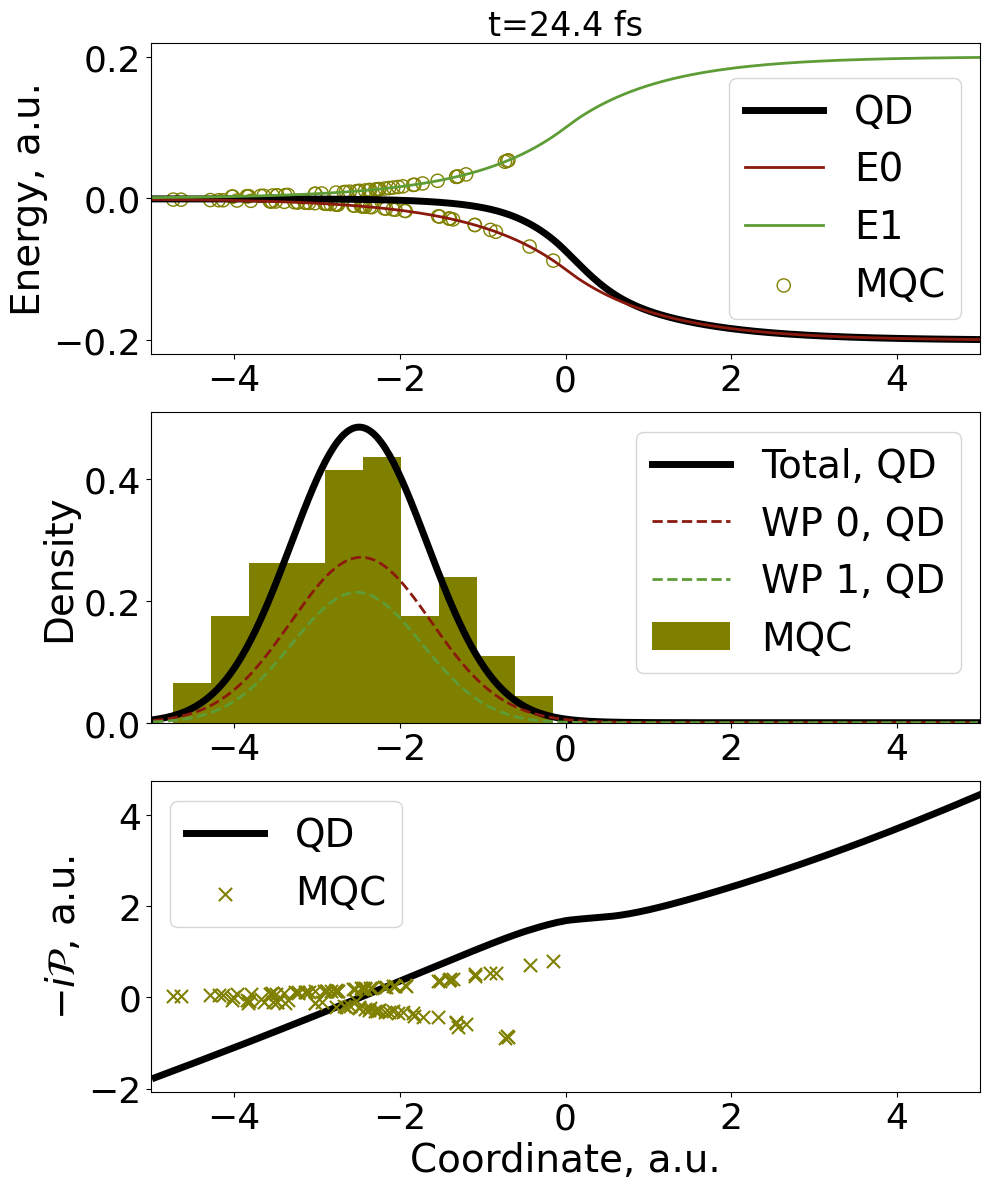

In [78]:
plot_snapshot(2, 0, [-5.0, 5.0],1000)

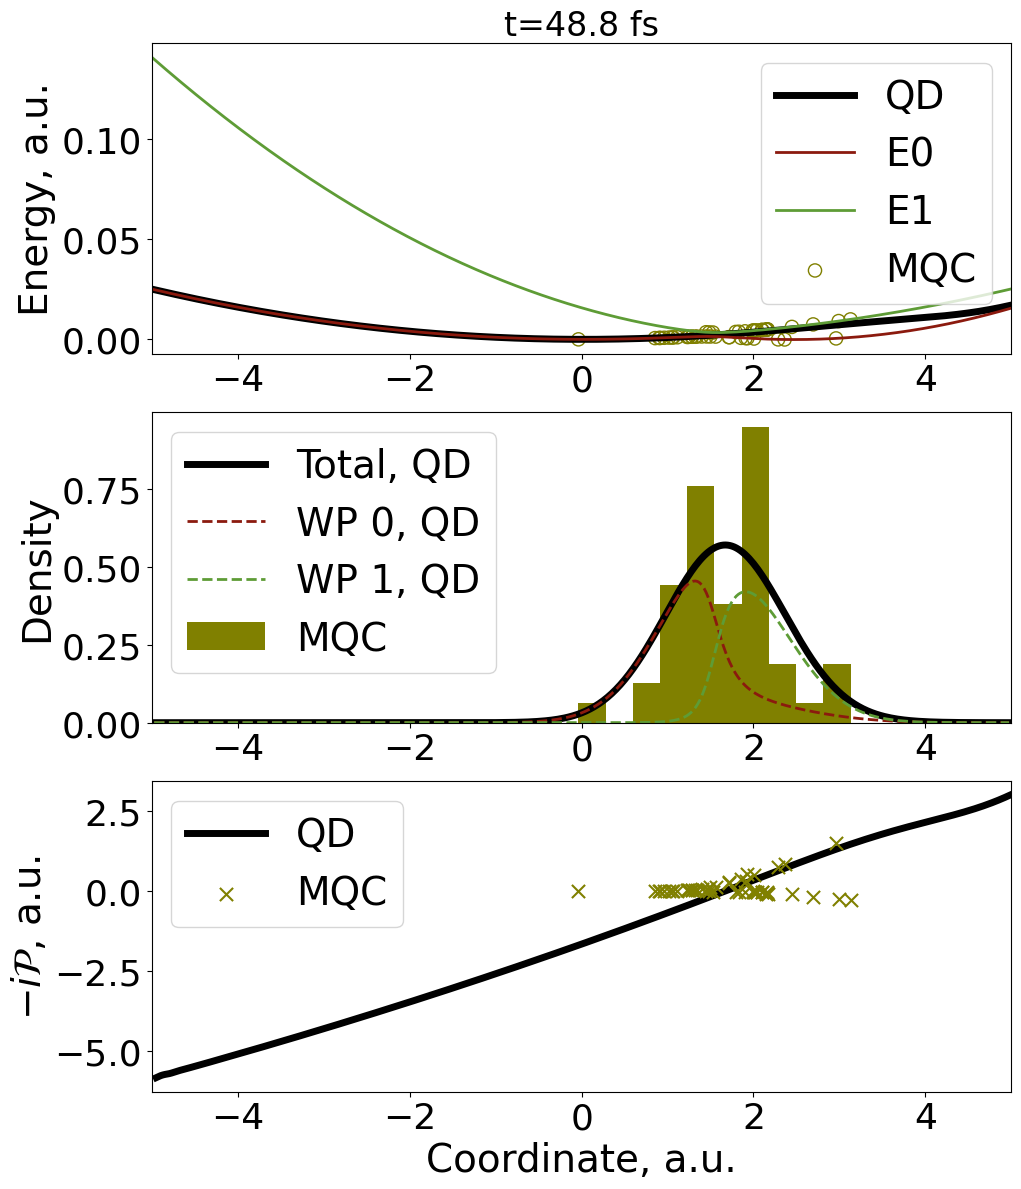

In [79]:
plot_snapshot(0, 0, [-5.0, 5.0],2000)

### Exercise 11
In the SC Holstein model, starting from ~75 fs, discrepancy in the coherence shows up between the MQC and quantum dynamics. What is the origin of this error?

### Exercise 12
The quantum momenta from trajectories are categorized into a few branches. Explain this by investigating the expression of the quantum momentum.
$$ -i\mathcal{P}_{\nu}(\mathbf{R},t) \approx \frac{\hbar}{2 \sigma_{\nu}} \left(\mathbf{R}_{a\nu}-\sum_{k} \rho_{kk} \mathbf{R}_{k\nu} \right). $$

## 11. Time-Dependent Width Approximations
<a name="11"></a>[Back to TOC](#TOC)

Here, we take a look at the dynamics results within the time-dependent width approximations.

With the same functions in <a name="1"></a>[Sec. 8.2](#S8.2), we can compare the results between the MQC and quantum dynamics.

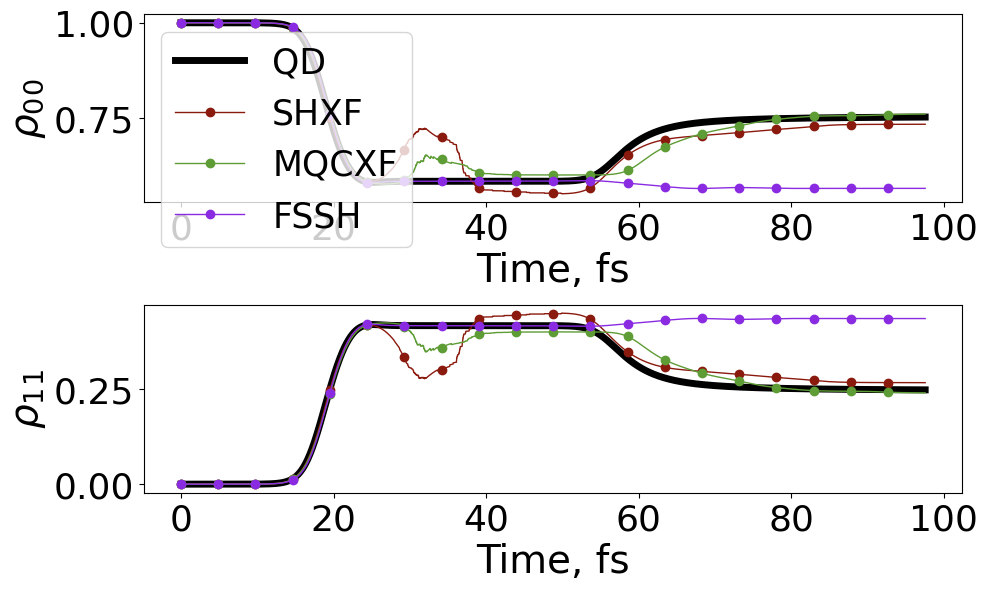

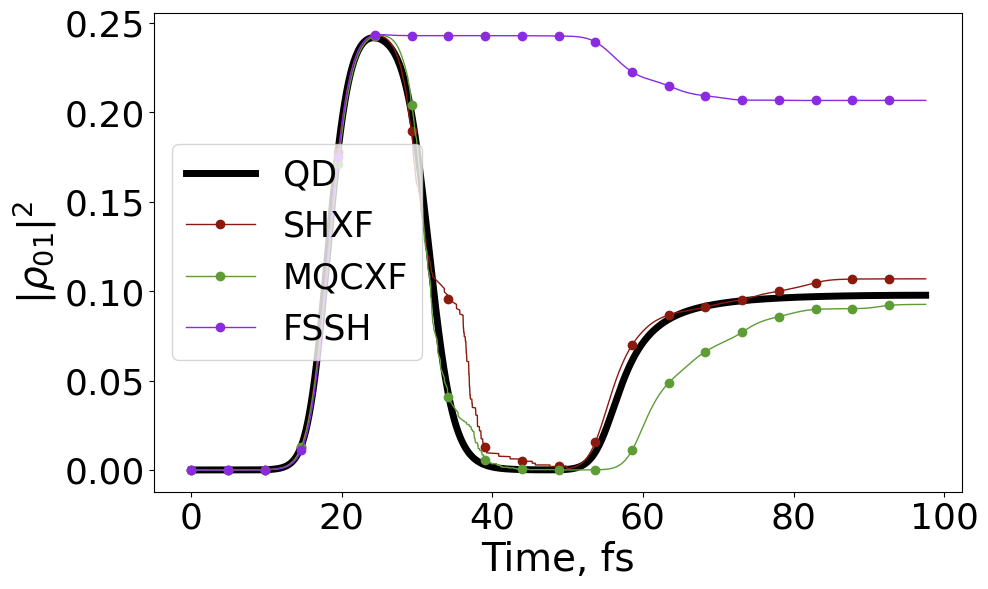

In [31]:
compare_pop(2, _param_indx=3); compare_coh(2, _param_indx=3)

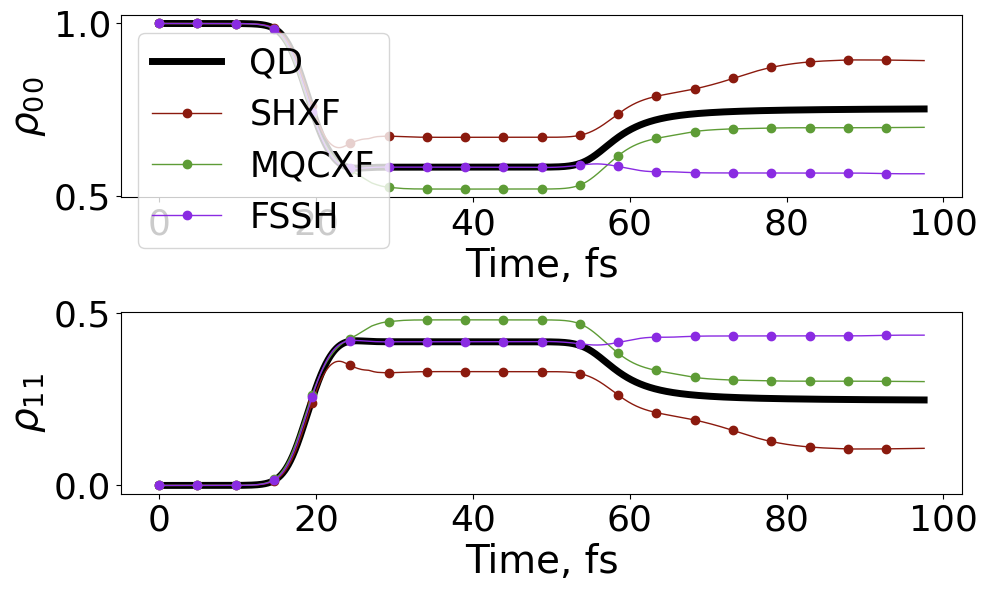

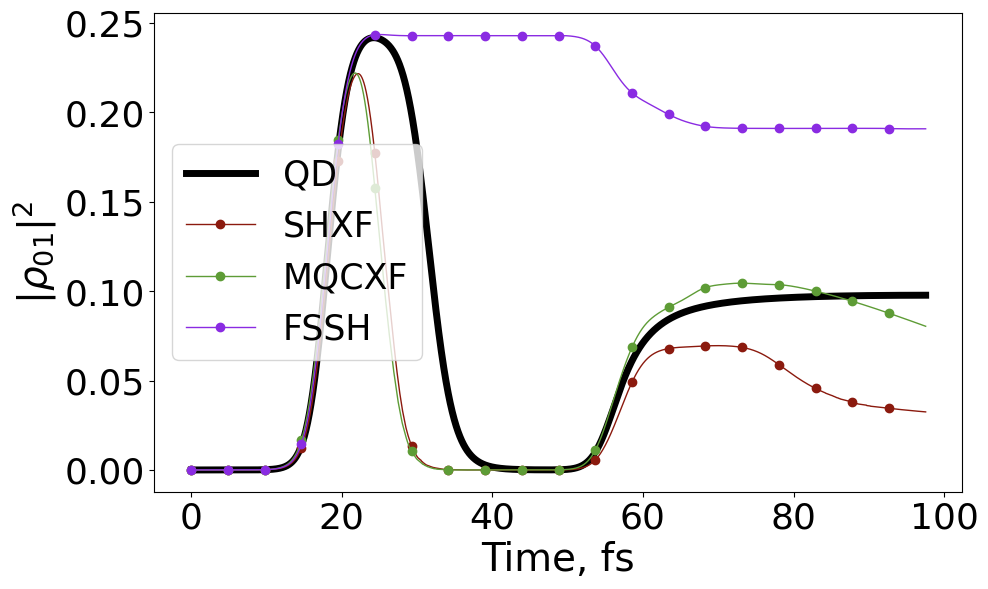

In [32]:
compare_pop(2, _param_indx=4); compare_coh(2, _param_indx=4)

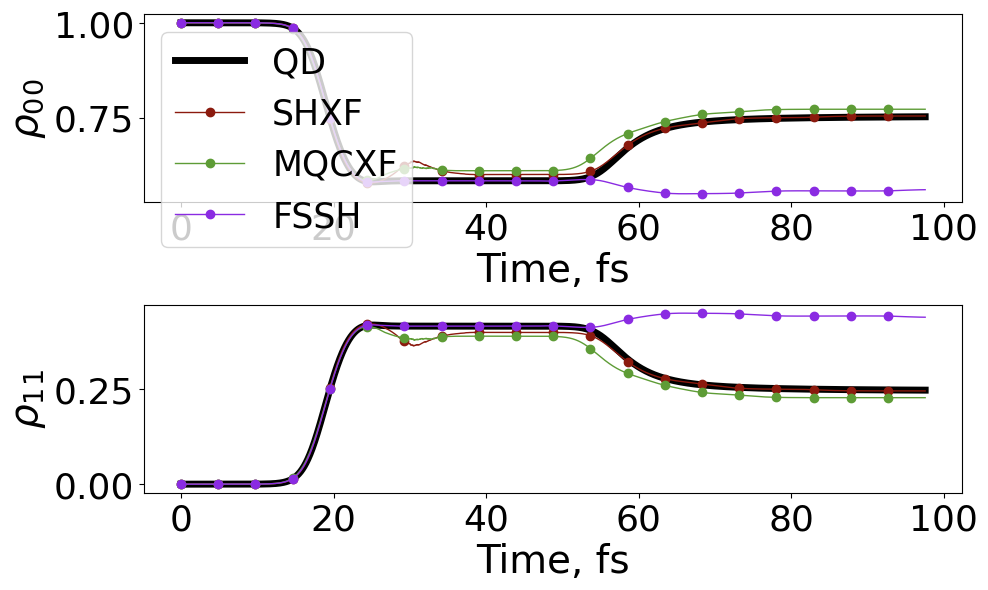

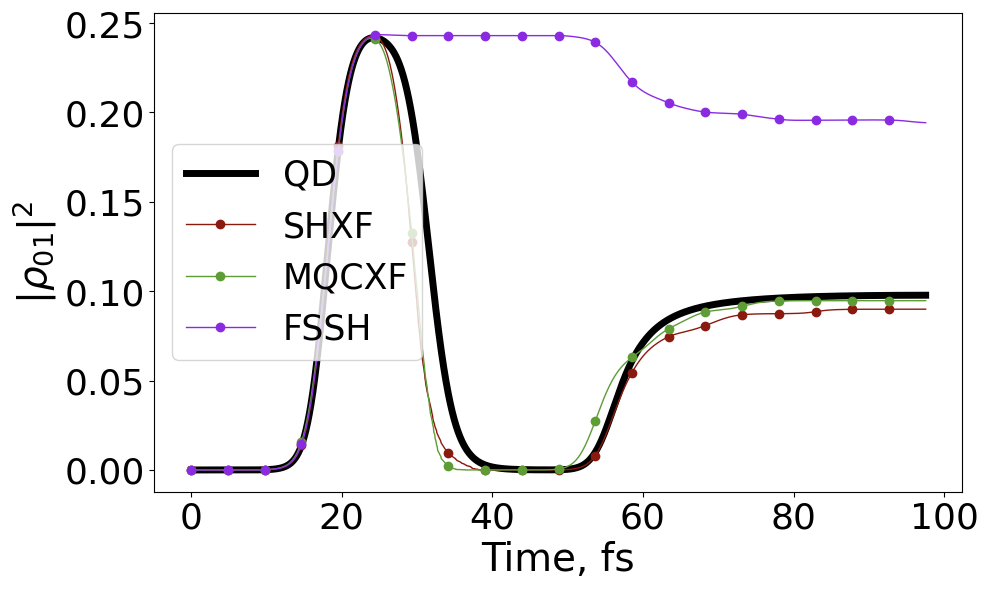

In [33]:
compare_pop(2, _param_indx=5); compare_coh(2, _param_indx=5)

We can track how the time-dependent widths behave over time.

In [47]:
def plot_widths(_model_indx, _method_indx, _variant_indx=0, _icond_indx=0, which_params=[3,4,5], _ylim=[0, 1.5]):
    
    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.set_ylim(_ylim)
    ax.set_xlabel("Time, fs")
    ax.set_ylabel("Width, Bohr")
    
    for i, param in enumerate(which_params):
        fn_MQC = F"model{_model_indx}-method{_method_indx}-param{param}-var{_variant_indx}-icond{_icond_indx}/mem_data.hdf"
        
        with h5py.File(fn_MQC, 'r') as f:
            ts = np.array(f["time/data"])
            if param==5: # Subotnik scheme, ignore when the decoherence algorithm is not activated
                WP = np.array(f["wp_width/data"][:,:,0])
                WP[WP >10000] = 0.0
                WP[WP == 0.0] = np.nan
            else:
                WP = np.abs(f["wp_width/data"][:,:,0])
            
        ntraj = WP.shape[1]
        ax.plot([], [], linewidth=2, color = colors[clrs_index[i]], label=F"param={param}")
        for traj in range(ntraj):
            ax.plot(ts/41.0, WP[:,traj], linewidth=2, color = colors[clrs_index[i]])
        ax.legend()


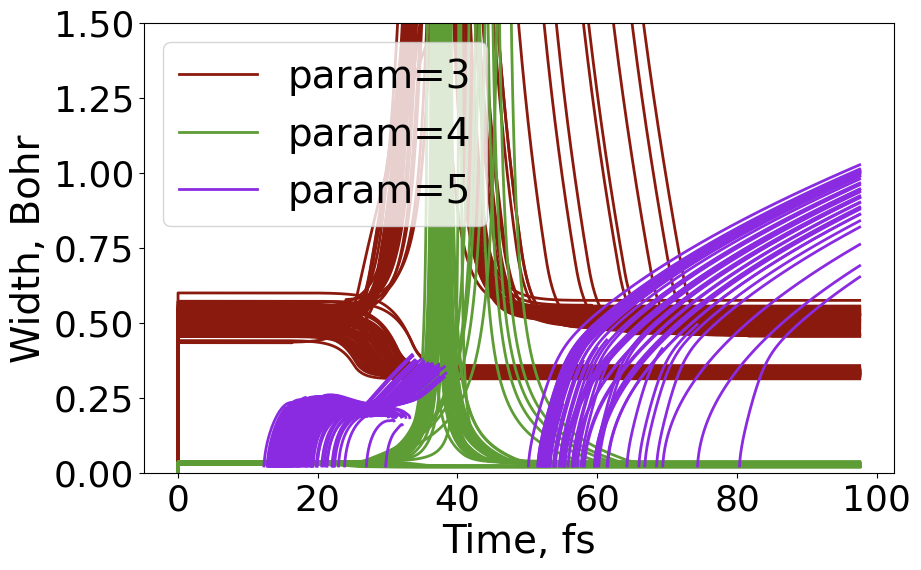

In [48]:
plot_widths(2,0)

### Exercise 13
Explain branching of the Schwartz widths in ECWR and DAG models.

### Exercise 14
Compute the average and standard deviation of the Subotnik widths.